In [1]:
"""
Data from

https://www.kaggle.com/selfishgene/historical-hourly-weather-data

(which is originally from OpenWeather API)

"""

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from datetime import datetime

import strat_models
import networkx as nx
import seaborn as sns
import cvxpy as cp
import matplotlib.pyplot as plt

from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split

from utils import ANLL, soft_threshold, offdiag, fit
np.random.seed(0)

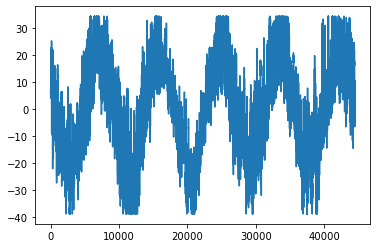

In [2]:
data = pd.read_csv("temperature.csv")
if "datetime" in data:
    hours = []
    day_of_years = []
    years = []
    for date in data["datetime"]:
        hours += [datetime.strptime(date, "%Y-%m-%d %H:%M:%S").hour]
        day_of_years += [datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday]
        years += [datetime.strptime(date, "%Y-%m-%d %H:%M:%S").year]
    data["hour"] = hours
    data["day_of_year"] = day_of_years
    data["year"] = years
    data = data.drop("datetime", axis=1)

data = data.dropna(0)

cities = ["Boston"]
strat_vals = ["hour", "day_of_year", "year"]

data = data[cities + strat_vals]
# convert from kelvin to fahrenheit\n",
data[cities] = (data[cities] - 273.15)*(9/5)+ 32

# # #make data zero mean\n",
for city in cities:
    data[city] -= data[city].mean()

data.sample(n=10)

data[cities] = winsorize(data[cities].values, limits=[0.01,0.01])
plt.plot(data[cities])
plt.show()

In [3]:
boston = data[cities]

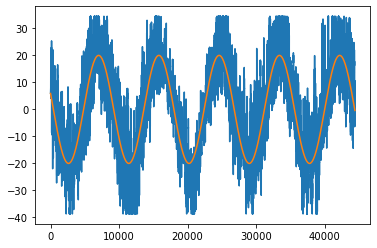

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


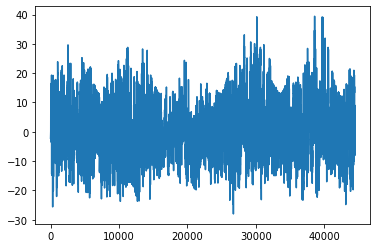

In [4]:
# data = pd.read_csv("temperature.csv")

# boston = data["Boston"]

# boston -= boston.mean()
# boston.dropna(inplace=True)
# plt.plot(data["Boston"])
y=np.array(boston)
n = len(y)//2

t = np.arange(len(y))
y = boston.values.flatten()

plt.figure()
plt.plot(y)
plt.plot(-20*np.sin(t/1400-0.3))
plt.show()

coss = [np.sin(t/1400-0.3).reshape(1,-1)]
sins = [np.cos(t/1400-0.3).reshape(1,-1)]

coss = np.vstack(coss)
sins = np.vstack(sins)
ones = np.ones((1, len(y)))

A = np.vstack([coss, sins, ones])
x = np.linalg.lstsq(A.T, y)[0]

boston = data[cities+strat_vals]
boston[cities] = y - A.T@x

data = boston.copy()
plt.plot(data[cities])
plt.show()

In [5]:

Y=[]
Z=[]
for doy in data.day_of_year.unique():
    y = []
    for year in data.year.unique():
        if len(np.array(data[data.day_of_year==doy][data.year==year][cities[0]]).reshape(-1,1)) != 24:
            continue
        y += [np.array(data[data.day_of_year==doy][data.year==year][cities[0]]).reshape(-1,1)]
        
    Y += y
    Z += [doy]*len(y)

Y_train, Y_, Z_train, Z_ = train_test_split(Y, Z, test_size=0.4, random_state=42)
Y_test, Y_val, Z_test, Z_val = train_test_split(Y_, Z_, test_size=0.5, random_state=42)

def get_yz_dict(Y, Z):
    Y_dict = []
    Z_dict = []
    for i in range(1, 366+1):
        if i in Z:
            idxs = [index for index, value in enumerate(Z) if value == i]
            Y_dict += [np.hstack([Y[idx] for idx in idxs])]
            Z_dict += [i]
        if i not in Z:
            Y_dict += [np.zeros((24,1))]
            Z_dict += [i]
    return Y_dict, Z_dict

Y_train, Z_train = get_yz_dict(Y_train, Z_train)
Y_val, Z_val = get_yz_dict(Y_val, Z_val)
Y_test, Z_test = get_yz_dict(Y_test, Z_test)

train_data = dict(Y=Y_train, Z=Z_train, n=24)
val_data = dict(Y=Y_val, Z=Z_val, n=24)
test_data = dict(Y=Y_test, Z=Z_test, n=24)

train_common_data = dict(Y=[(np.hstack(Y_train))], Z=[0], n=24)
val_common_data = dict(Y=[(np.hstack(Y_val))], Z=[0], n=24)
test_common_data = dict(Y=[(np.hstack(Y_test))], Z=[0], n=24)

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

In [6]:
Y=[]
Z=[]
for doy in data.day_of_year.unique():
    y = []
    for year in data.year.unique():
        if len(np.array(data[data.day_of_year==doy][data.year==year][cities[0]]).reshape(-1,1)) != 24:
            continue
        y += [np.array(data[data.day_of_year==doy][data.year==year][cities[0]]).reshape(-1,1)]
        
    Y += y
    Z += [doy]*len(y)

Y_train, Y_, Z_train, Z_ = train_test_split(Y, Z, test_size=0.4, random_state=42)
Y_test, Y_val, Z_test, Z_val = train_test_split(Y_, Z_, test_size=0.5, random_state=41)

ys_train = np.hstack(Y_train).T
ys_val = np.hstack(Y_val).T
ys_test = np.hstack(Y_test).T

zs_train = np.array(Z_train)-1
zs_val = np.array(Z_val)-1
zs_test = np.array(Z_test)-1

ys = np.hstack(Y).T
zs = np.array(Z)-1

K=366

print("Number of samples per node:", len(zs_train)/K)

num_zero = 0
max_num = 0
for i in range(K):
    if (zs_train == i).sum() > max_num:
        max_num = (zs_train == i).sum()
    if i not in zs_train:
        num_zero += 1
        ys_train = np.vstack((ys_train, np.zeros(24)))
        zs_train = np.array(list(zs_train) + [i])
        
print("Training data statistics:")
print("\tMax number of samples on a node is", max_num)
print("\tNumber of nodes with zero samples is", num_zero)

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8:

Number of samples per node: 3.0163934426229506
Training data statistics:
	Max number of samples on a node is 6
	Number of nodes with zero samples is 7


/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:6:

In [7]:
#Stratified model
#make L
G = nx.cycle_graph(366)
strat_models.set_edge_weight(G, 1)
L = nx.laplacian_matrix(G)

wt = 6000
lam_1 = 0.1
lam_2 = .14

theta, _, _ = fit(zs=zs_train, ys=ys_train, L=wt*L, lam_1=lam_1, lam_2=lam_2, rho=10, maxiter=10000, 
                                    verbose=True, warm_start=None, eps_abs = 1e-3, eps_rel = 1e-3)

print(wt, lam_1, lam_2, "ANLL:", ANLL(ys_val, zs_val, K=366, theta=theta)[0], ANLL(ys_test, zs_test, K=366, theta=theta)[0])

Fitting covariance stratified model.
366 stratification values, 1111 data points, 24 dimensions
210816 optimization variables
lam_1 = 1.000e-01, lam_2 = 1.400e-01, rho = 1.000e+01, maxiter=10000
count per stratification value: [1, 3, 2, 3, 5, 4, 3, 3, 4, 1, 2, 4, 3, 4, 1, 3, 4, 2, 4, 4, 1, 2, 3, 2, 3, 2, 2, 1, 4, 2, 3, 4, 3, 5, 3, 4, 4, 5, 3, 2, 2, 5, 3, 3, 3, 1, 2, 4, 2, 4, 3, 4, 3, 2, 4, 1, 4, 2, 3, 4, 2, 3, 4, 4, 3, 2, 2, 2, 3, 3, 4, 4, 2, 3, 5, 3, 3, 4, 4, 3, 3, 3, 3, 4, 2, 1, 4, 2, 4, 2, 3, 4, 1, 3, 1, 5, 4, 2, 5, 2, 3, 1, 3, 3, 2, 3, 3, 4, 4, 2, 4, 3, 3, 4, 2, 3, 2, 5, 4, 3, 2, 4, 3, 3, 5, 2, 2, 2, 3, 4, 3, 3, 4, 1, 5, 5, 3, 3, 4, 2, 2, 5, 3, 4, 4, 2, 3, 4, 3, 1, 2, 1, 3, 4, 4, 2, 5, 4, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 1, 3, 3, 3, 1, 4, 3, 3, 3, 5, 2, 2, 2, 4, 2, 3, 3, 5, 4, 3, 4, 2, 4, 5, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 2, 5, 3, 2, 4, 4, 1, 3, 5, 3, 3, 1, 4, 1, 3, 2, 4, 3, 3, 5, 2, 5, 2, 3, 3, 4, 2, 1, 4, 4, 3, 3, 4, 4, 5, 3, 3, 4, 3, 4, 3, 2, 4, 4, 2, 1, 3, 4, 4, 4, 3, 3, 4, 2

1.7483206804908253 2.8565947668876217 0.8630647964255526 0.7853110765387805
1.7328351296633957 2.819377167045739 0.8628332555517403 0.7867822076115463
1.7175678157581205 2.78372539841662 0.862602590498804 0.7882400239556829
1.7026574200768203 2.7484767538257286 0.8623728823689432 0.7896847674249159
1.6880084002015803 2.7138596111703426 0.8621442165266585 0.7911166710957693
1.6736026439713272 2.6802397746895386 0.8619166691684498 0.7925359590961825
1.659492120187656 2.6469459587431654 0.8616903088245915 0.7939428543468963
1.6456053755662179 2.613947541469068 0.8614652045821745 0.7953375723142355
1.6319805620097165 2.5813338643545656 0.8612414181942606 0.7967203242818314
1.6185630255406382 2.549665367448984 0.8610190050308428 0.7980913151891471
1.6054326056443349 2.5182137759171948 0.8607980140506493 0.7994507457780033
1.5925097928286203 2.487266287796604 0.8605784939396508 0.8007988115322546
1.5798050632081466 2.456711746463094 0.8603604865399588 0.8021357041442867
1.5672953177197637 2.

0.9071823612838142 0.801307251125119 0.8469225182734241 0.8971999541068496
0.9033060615905305 0.7927872087096297 0.8468458450878542 0.8979416056690686
0.899461171824142 0.7843592300040066 0.846770002885833 0.8986799077606941
0.8956514953091884 0.7760413638630338 0.8466949803493506 0.8994148898750004
0.8918732541646597 0.7678314247621305 0.846620766284607 0.9001465810290272
0.8881295653613359 0.7597281063862116 0.8465473491081804 0.9008750100817889
0.8844150320641135 0.7517368121739203 0.8464747176439607 0.9016002051473941
0.8807324032691847 0.7438592227868226 0.8464028609949135 0.9023221942243534
0.8770789010772019 0.7360868552246707 0.8463317685938522 0.9030410046963271
0.8734570544560791 0.7284264200800379 0.8462614303071538 0.9037566635724936
0.8698653201534688 0.7208693876730355 0.8461918360488786 0.9044691976044614
0.8663011321063964 0.7134068471682978 0.8461229762246834 0.9051786327175239
0.8627675910202676 0.7060445273869225 0.8460548401297697 0.9058849948335644
0.85926242126553

0.6149224487085158 0.29769100955596095 0.841753520706608 0.9633482412563614
0.6130986707278802 0.2955206175975719 0.8417257097806161 0.9638389749964409
0.6112863857656492 0.293374119810916 0.8416981103294743 0.9643281542697721
0.6094838766853931 0.2912443329109967 0.8416707193827437 0.9648157878541845
0.6076911765663001 0.28914334135648356 0.8416435340060299 0.9653018845023782
0.6059081363824431 0.2870673958761895 0.8416165517916921 0.965786452864154
0.6041343062180542 0.2850177197915989 0.8415897701757468 0.9662695015261487
0.6023686604524724 0.2829892026013056 0.8415631866009151 0.9667510389613825
0.6006118333888756 0.2809987075252312 0.8415367989815182 0.9672310735807546
0.5988673676496079 0.27901982285426 0.8415106060622259 0.9677096137350598
0.5971308776272028 0.2770597451218938 0.8414846062477073 0.9681866675997612
0.5954045567628605 0.2751219291730077 0.8414587979441421 0.9686622433511558
0.5936892090106058 0.27319354794685824 0.8414331795241112 0.9691363491442941
0.591983531567

0.46187703628589116 0.1513790546800819 0.8396136324185355 1.0091898628280986
0.4607992853015017 0.15056729623786919 0.8396000104088549 1.0095506025026817
0.45972677915622584 0.14975376515165706 0.8395864665240216 1.0099104305573328
0.4586576349243092 0.14895380985065718 0.8395730000864241 1.0102693508476852
0.457594047503131 0.14815627699901354 0.8395596103882002 1.0106273673436372
0.4565352383020222 0.14735674516931524 0.8395462968244147 1.0109844838837485
0.45548063162919306 0.14656467449888178 0.8395330584971604 1.011340704293226
0.4544297213803848 0.14578260640093524 0.8395198946391361 1.011696032346973
0.45338134285351545 0.14502006705841355 0.8395068046231835 1.0120504718060954
0.4523390560081705 0.14425782049880637 0.8394937884310183 1.0124040263268077
0.45130208784236436 0.14348533314617154 0.8394808457453513 1.0127566996798172
0.450268811212897 0.14271219609095565 0.8394679760371608 1.0131084956129202
0.44923827852242754 0.14195175128636944 0.8394551786201414 1.013459417793265

0.36761923307186856 0.09020412514225705 0.838503306608975 1.0432848602519096
0.36690201622176405 0.08980510369534628 0.8384954794873438 1.043566167668006
0.36618745424901267 0.08941179906277921 0.8384876887150935 1.043846873444531
0.3654749007937339 0.08902941283321032 0.838479933886378 1.0441269796489985
0.3647656437814184 0.08864716764657549 0.8384722146302384 1.0444064884360686
0.36405790287350137 0.08827083333294583 0.8384645306986335 1.0446854018770537
0.36335347369890114 0.08789369490600743 0.8384568819286757 1.044963722078939
0.3626513192659312 0.08751634834199024 0.8384492680557802 1.0452414511408503
0.36195131276440673 0.08714412069891869 0.8384416888304695 1.0455185911231235
0.3612540397349409 0.08677334062862643 0.8384341439911507 1.0457951440917013
0.3605592441744042 0.08640321720490635 0.8384266332408314 1.046071112143088
0.35986630828007554 0.08604113661195553 0.838419156245001 1.0463464973010852
0.3591747689764948 0.08569105466418013 0.8384117127787374 1.0466213015993446

0.3027482456383275 0.058978023866441416 0.8378356671535833 1.0703447973059803
0.30223789225519015 0.058773908638950656 0.837830733319189 1.0705719321289133
0.30172921139594405 0.05856005549155684 0.8378258197289883 1.0707986427387595
0.30122183434362526 0.05833959307289541 0.8378209264006615 1.0710249303990167
0.3007159288012937 0.05811531429973101 0.8378160533058159 1.0712507963822575
0.30021096093476524 0.057891231578363435 0.8378112004056417 1.0714762419453536
0.2997077740620144 0.057665825195730255 0.8378063677105315 1.071701268366199
0.29920620202160864 0.057438877299790796 0.8378015551856659 1.0719258769096065
0.2987056719229713 0.057211617237397386 0.8377967627279523 1.0721500688149834
0.2982055778698177 0.05699223067531151 0.8377919901672906 1.07237384529407
0.2977077492787936 0.05677791036881345 0.8377872372761188 1.0725972076303196
0.29721210667615183 0.056564188339183294 0.8377825038703067 1.072820157085218
0.2967179646751003 0.05634812214213761 0.8377777897373205 1.07304269

0.2554540702247646 0.040913628058285564 0.8374047986635447 1.0924706449740083
0.25507273172144784 0.040804255256065486 0.8374015199769671 1.0926586837547014
0.2546921749403133 0.040693585517391655 0.837398252001784 1.0928464091939574
0.254311932759834 0.04059176697228359 0.8373949946985241 1.0930338220867837
0.2539328788583069 0.04049510616035973 0.8373917481351204 1.0932209232434564
0.2535554303712076 0.04039203891665649 0.8373885125152147 1.0934077134761906
0.25317913907403994 0.040281308201894996 0.8373852879141986 1.0935941935943827
0.25280352457228267 0.040167211703857994 0.8373820743257865 1.0937803643740605
0.2524290758244727 0.04004944181428702 0.8373788716978702 1.0939662266251324
0.25205549558499624 0.039929547466318105 0.8373756799890204 1.0941517811511572
0.2516827061382019 0.039809444593102324 0.8373724991332901 1.0943370287632466
0.25131081886714973 0.039689240397362935 0.837369329037308 1.0945219702641462
0.2509400708651102 0.039569299290012766 0.8373661696226204 1.09470

0.21980356651209135 0.029772009308746482 0.8371116268324595 1.1108044515402404
0.2195075391530299 0.029696232378225277 0.837109315940438 1.1109633495116187
0.21921217375358162 0.029622291856261803 0.8371070132707257 1.1111220070957986
0.218917820583434 0.029548243451784653 0.8371047189042223 1.1112804248696055
0.21862408468759184 0.02947189747778747 0.8371024329957009 1.1114386033804309
0.2183310367235091 0.029392833928504662 0.8371001556267517 1.1115965431891863
0.21803853631474898 0.02931296975666426 0.837097886834097 1.111754244855049
0.217745890449471 0.029242603657013134 0.8370956266179549 1.1119117089219368
0.21745470173746026 0.02916901956872787 0.8370933751457277 1.1120689359508575
0.21716425697631733 0.029091447826708517 0.8370911324461092 1.1122259265118926
0.21687445758530227 0.02901188682102296 0.8370888985219027 1.1123826811578934
0.21658447536059994 0.02893778974648441 0.837086673349589 1.1125392004220367
0.21629585929853787 0.028860965493008865 0.8370844569267932 1.11269

0.19178051717554276 0.0222530894887148 0.8369059343872407 1.1264110503230012
0.19154498541320794 0.0222008467298299 0.836904286633159 1.126547308613124
0.19130990119939795 0.022147440090209747 0.8369026434292879 1.1266833777671783
0.19107536656386073 0.02209335693966011 0.8369010047449885 1.1268192581986398
0.19084128967433356 0.022038465376519323 0.8368993705370109 1.1269549503157685
0.1906076852986309 0.021982849757361422 0.8368977407601533 1.1270904545247957
0.19037443801060133 0.02192708380881109 0.8368961153496633 1.1272257712366323
0.19014176067180494 0.021871431552616026 0.8368944942674185 1.1273609008581074
0.1899093591249588 0.02181684214221787 0.8368928774657297 1.127495843788259
0.18967752397115625 0.021763663412256613 0.8368912649060511 1.1276306004311256
0.1894461565982636 0.021708164369922584 0.8368896565398722 1.127765171186179
0.18921534183135066 0.021652025587756384 0.8368880523560098 1.1278995564515215
0.18898500661803383 0.021595932397743742 0.836886452326429 1.12803

0.1690295794686278 0.017056927969917337 0.8367527970999318 1.1399929851986697
0.16883814575683678 0.017016935035975112 0.8367515696319439 1.1401110911148655
0.16864707911072319 0.016976750510276566 0.8367503453303325 1.1402290452921344
0.16845641009610698 0.016937231660891765 0.8367491241855389 1.1403468480310754
0.16826612177091732 0.016898349324289526 0.8367479061868512 1.1404644996349744
0.1680760941322199 0.016860092965902927 0.8367466912970266 1.1405820004043834
0.16788640680427572 0.016823545387614942 0.8367454794960859 1.1406993506361842
0.1676971745320198 0.016786181547005764 0.8367442707767092 1.1408165506281287
0.1675082824542606 0.016748130226107678 0.8367430651044667 1.1409336006745832
0.16731972933740163 0.01670995011277273 0.8367418624555579 1.141050501069477
0.16713154115491138 0.01667171212196714 0.8367406628085277 1.1411672521093998
0.16694369587582594 0.016633255652115486 0.8367394661378128 1.1412838540886223
0.1667561806712308 0.016594125360806452 0.8367382724241887 

0.15037920644519634 0.013394059123341124 0.8366376494409361 1.1518250790045235
0.15022078413839074 0.013367174442604497 0.8366367179442875 1.1519284900829931
0.1500624891705991 0.013339506351750893 0.8366357887793647 1.1520317771580046
0.14990459330506342 0.013311554713997647 0.8366348619322527 1.1521349404588037
0.14974672994319493 0.013283668374759233 0.8366339373880965 1.1522379802109093
0.14958932307296255 0.01325634732420663 0.836633015169304 1.152340896634365
0.14943215999934115 0.013227760340042702 0.836632095299271 1.152443689949152
0.1492751569730385 0.013203007246073938 0.8366311777749694 1.1525463603667725
0.14911859800724764 0.013176636518158084 0.8366302625960594 1.1526489081047466
0.14896230519165393 0.013149504473518389 0.83662934976769 1.1527513333838717
0.1488062261902469 0.013123149344571301 0.8366284392790226 1.1528536364212416
0.14865044463089555 0.013096680503722351 0.8366275311290885 1.1529558174408732
0.14849493658781318 0.013070338007909105 0.8366266252978733 1.

0.13481678624491258 0.010724774787269466 0.8365508021907405 1.1622283230600254
0.13468360106037855 0.010704192626513145 0.8365501009745281 1.1623196276796295
0.1345504478653086 0.010685245490151759 0.8365494015994006 1.1624108293327808
0.13441763864195777 0.010665334302194879 0.836548704089447 1.1625019281970572
0.13428503139828155 0.010644518009936908 0.836548008448493 1.1625929244391882
0.13415267764482566 0.010622781011120859 0.8365473146639244 1.162683818232435
0.13402051867555395 0.010600833236240425 0.8365466227240586 1.1627746097482416
0.13388848331656036 0.010578610604542979 0.8365459326188753 1.1628652991561144
0.13375671065289227 0.010557424730892245 0.8365452443175012 1.162955886629615
0.1336251197601075 0.010535257084255305 0.8365445578031907 1.1630463723372724
0.13349378301193077 0.010512388878468091 0.8365438730540337 1.1631367564486637
0.13336268806418863 0.01048854776057786 0.8365431900584934 1.1632270391386217
0.13323179062995075 0.010464367688882476 0.8365425088070517

0.12177541157328531 0.008739937710429972 0.8364844192437855 1.17136514577893
0.12166197718523267 0.008724934611455886 0.8364838585080908 1.171446427500508
0.12154867601850122 0.008710623187775624 0.8364832990080409 1.1715276225691966
0.12143550833357507 0.008695552865616123 0.836482740751463 1.1716087311218153
0.1213225228710612 0.008680815044649794 0.8364821837416756 1.1716897532929351
0.12120971467360146 0.00866651875857266 0.8364816279750173 1.1717706892193085
0.12109711166257392 0.008651993699577568 0.836481073450133 1.1718515390359254
0.1209846541233484 0.008637681129296172 0.8364805201599274 1.1719323028744815
0.12087236214172466 0.008624146112567753 0.8364799681008048 1.172012980867097
0.12076025075022 0.008610737412058814 0.8364794172821384 1.172093573149591
0.12064829170468533 0.008597241732846348 0.8364788677086007 1.1721740798546805
0.12053649057114176 0.008583634239696065 0.8364783193846057 1.172254501114429
0.12042483844063381 0.008569926401283227 0.8364777723172521 1.1723

0.1107030659991806 0.007250743600396705 0.8364320520444528 1.1794507251931161
0.11060521390605574 0.0072394395342589915 0.8364316173369803 1.1795235977583283
0.1105074948639424 0.00722820335530257 0.8364311837788635 1.1795963964420253
0.11040980523759344 0.0072168904327685884 0.8364307513638036 1.1796691213514812
0.11031235724331115 0.007203884687962761 0.8364303200954483 1.179741772596091
0.11021505082907469 0.007188790345234571 0.8364298899728192 1.1798143502857308
0.11011781924741466 0.007172974982994781 0.8364294609844066 1.179886854526847
0.1100207488037903 0.007157391741039259 0.8364290331166087 1.179959285428715
0.10992381836583226 0.007142032926576812 0.8364286063509467 1.1800316431012867
0.10982703906576254 0.007126822202016478 0.8364281806700324 1.1801039276546978
0.1097303714447577 0.007111924032975947 0.8364277560564168 1.1801761391966814
0.10963385607775149 0.0070972921805733235 0.8364273324715645 1.1802482778385686
0.10953713655669707 0.007088040262523991 0.83642690988222

0.10102389838591479 0.005959244014588454 0.8363909327810688 1.1867841023021712
0.1009387883653747 0.0059487293334151035 0.8363905868560259 1.1868497109799498
0.10085380195984309 0.0059379461046751595 0.8363902416347997 1.186915256205578
0.1007688772613912 0.005927884736495449 0.8363898971171286 1.1869807380663167
0.10068407541418381 0.00591937673853649 0.8363895532987903 1.1870461566490205
0.10059944836018318 0.0059108245196373595 0.8363892101643682 1.187111512044155
0.10051493687803291 0.005902040178794604 0.8363888676972229 1.1871768043401367
0.10043053373916594 0.005893602311019034 0.8363885258842544 1.187242033625435
0.10034623894850148 0.005885652766669017 0.8363881847135911 1.187307199988654
0.10026205237008813 0.0058780336795207985 0.8363878441759762 1.1873723035180335
0.10017796426727509 0.005870460456803562 0.8363875042651698 1.187437344299979
0.10009399319723422 0.005862857286767373 0.8363871649758541 1.1875023224233912
0.10001012962493434 0.005855074979408797 0.8363868263067

0.0925042082177883 0.005055074219414996 0.8363573014838032 1.1934611204919172
0.09242975055487826 0.0050482849358921295 0.8363570140696527 1.1935204097611503
0.09235542168738613 0.0050414599619173365 0.8363567270970858 1.1935796441472586
0.09228118986446414 0.005034399826449585 0.8363564405679648 1.1936388237225795
0.0922070486562164 0.0050272311430352564 0.8363561544831899 1.1936979485597703
0.09213299288345633 0.0050200196173517675 0.8363558688448824 1.1937570187306983
0.09205899932616077 0.005013015753309466 0.8363555836550736 1.1938160343063422
0.09198511656372073 0.0050058498194752365 0.8363552989195234 1.1938749953585388
0.09191133301951425 0.0049984220671494845 0.8363550146344727 1.1939339019612467
0.0918376334357915 0.004990849287504803 0.836354730798186 1.1939927541859274
0.0917640019160727 0.004983156014991206 0.8363544474099391 1.19405155210226
0.09169047616704915 0.004975464902752499 0.8363541644702956 1.1941102957832799
0.09161704714586198 0.004967749554496769 0.8363538819

0.08502252155645496 0.004293928697784607 0.8363292834161621 1.1995075331805565
0.08495693219126363 0.004286710633100424 0.8363290501311744 1.1995613351419274
0.08489141414297374 0.004279354331922878 0.8363288173033291 1.199615089264917
0.08482595735442176 0.004271896689881527 0.8363285849269217 1.1996687956082877
0.08476059052124704 0.004264467592432088 0.8363283529931718 1.1997224542331235
0.08469529120927409 0.004256982319721974 0.836328121493056 1.1997760651998952
0.08463001364622211 0.004250021291868324 0.836327890420059 1.1998296285635905
0.08456486607945651 0.0042428901654142405 0.8363276597703813 1.199883144386619
0.0844998011100797 0.0042352450696346204 0.8363274295430586 1.1999366127297666
0.08443480758546609 0.00422761775742538 0.83632719973258 1.1999900336525244
0.08436989170815341 0.004220244190593351 0.836326970331667 1.2000434072149646
0.084305046418496 0.004213111093771897 0.8363267413317167 1.2000967334769255
0.0842402728072151 0.004206319627729528 0.8363265127248076 1.

0.0784660100645637 0.0036499249659827067 0.8363066344631501 1.2049553749547932
0.07840775167837476 0.0036449130620495877 0.8363064398923702 1.2050044201608265
0.07834957354406855 0.0036400078710840354 0.8363062456401851 1.205053423341046
0.07829146016482957 0.0036350592109166426 0.8363060517045956 1.205102384545498
0.07823324907112701 0.003632334600538484 0.8363058580845044 1.2051513038176251
0.0781752454665503 0.003631005317060782 0.836305664799644 1.2052001812069901
0.07811731917745805 0.0036289730912261163 0.8363054718856368 1.2052490167623333
0.07805945517007483 0.0036263014596762057 0.8363052793686953 1.205297810530348
0.07800165396101778 0.003622880655082928 0.8363050872662465 1.2053465625586635
0.07794391595629191 0.003618670291213976 0.8363048955901959 1.2053952728962094
0.07788623912547714 0.003613901975283871 0.836304704347322 1.205443941592267
0.07782862671122888 0.003608818645938048 0.8363045135403507 1.20549256869679
0.0777710740104389 0.0036036435479409176 0.8363043231682

0.07273235071518536 0.0031644697879310334 0.8362882756311261 1.209839702851292
0.07268024686270987 0.0031608765041565654 0.8362881141871428 1.2098846309186124
0.07262819756130545 0.0031571780631245534 0.8362879529944539 1.2099295217644186
0.07257619916223045 0.00315334468305136 0.8362877920511029 1.2099743754310572
0.07252425766685205 0.00314947718913757 0.8362876313549422 1.2100191919611711
0.07247236631487743 0.003145854688220147 0.8362874709037338 1.210063971396583
0.07242053364496683 0.003142509249949834 0.8362873106964773 1.2101087137802102
0.0723687230212006 0.0031393391908945316 0.8362871507365985 1.2101534191536798
0.07231697790065367 0.00313677241613834 0.836286991025408 1.2101980875579708
0.07226528505462156 0.003134419864611649 0.8362868315623976 1.2102427190360319
0.07221366773822532 0.0031319781866010815 0.8362866723599353 1.2102873136308774
0.07216210183603694 0.003129387243133239 0.836286513417714 1.2103318713834539
0.0721105897388478 0.0031266792921526977 0.836286354737

0.06759059603972867 0.0027684843854217807 0.8362728093360774 1.2143203140403336
0.06754375331241878 0.002764673674782912 0.8362726728173635 1.2143615873165556
0.06749695519440842 0.002760705607903498 0.8362725365112382 1.214402827459626
0.06745020554167877 0.002756874213336521 0.8362724004184506 1.214444034505739
0.0674034979757651 0.002753396594968356 0.8362722645388324 1.2144852084913498
0.0673568423749162 0.002749911956152593 0.8362721288783301 1.214526349452746
0.06731023356994782 0.002746304289805551 0.8362719934375442 1.2145674574261187
0.06726367138874875 0.002742622401782676 0.8362718582162634 1.2146085324476812
0.06721715562173101 0.0027389303844015545 0.8362717232137029 1.2146495745534591
0.06717068656784564 0.002735225701643757 0.8362715884285263 1.2146905837797377
0.06712426399465317 0.0027315094279917124 0.8362714538596907 1.2147315601625108
0.06707788783728548 0.0027277746738083785 0.836271319506305 1.214772503737684
0.06703155802914727 0.0027240128580473377 0.83627118536

0.06287337080676764 0.0024080029416450755 0.8362595178593615 1.2185176337429366
0.06283114892699271 0.0024038509609084976 0.8362594038439134 1.2185555867365876
0.06278896775865118 0.002399815159919291 0.8362592900795756 1.2185935101581016
0.06274682599750826 0.002395878987042342 0.8362591765621662 1.218631404038776
0.06270472050144114 0.0023921651788065806 0.836259063288177 1.218669268408782
0.06266266091468944 0.0023884428250800093 0.836258950258697 1.2187071033005128
0.06262063908745495 0.0023847258114227535 0.8362588374743695 1.218744908744498
0.06257866009374251 0.0023810617378062096 0.8362587249331495 1.2187826847720704
0.06253672163033296 0.002377429751838959 0.8362586126326896 1.2188204314143698
0.062494823470093615 0.0023738278704788693 0.8362585005700269 1.2188581487024204
0.06245295559368917 0.0023702632585340076 0.8362583887419662 1.2188958366668086
0.06241112956477872 0.002366931950198453 0.8362582771449449 1.2189334953381004
0.06236935072968618 0.0023635214046804514 0.8362

0.05868964466252891 0.0021134053421359325 0.8362486848651258 1.2223118402002313
0.058651365706428614 0.0021110703638510296 0.8362485890207494 1.2223468769835042
0.05861312328952561 0.002108642518100137 0.8362484933227378 1.2223818872129248
0.05857491728106355 0.002106049730594666 0.8362483977716607 1.2224168709155863
0.058536746742991926 0.0021032930746700553 0.8362483023674023 1.2224518281184564
0.058498601842036896 0.0021005378018920224 0.836248207110142 1.2224867588476853
0.05846050163250534 0.002097765546659483 0.8362481119993049 1.2225216631308726
0.05842242790175648 0.0020948322183248448 0.8362480170349498 1.2225565409945933
0.05838439730760932 0.0020919059172722185 0.8362479222268477 1.222591392465712
0.05834640299868546 0.002088912403094239 0.8362478275839431 1.2226262175708453
0.05830844386562747 0.0020858278100646527 0.8362477331110441 1.222661016336463
0.05827051984425137 0.002082626942227243 0.836247638811241 1.2226957887891106
0.05823263089023896 0.0020793168695823266 0.83

0.05489054276208656 0.0018440954688124505 0.8362395528402374 1.2258181938870851
0.05485567065884426 0.0018423095381895419 0.8362394725704088 1.2258506072198763
0.054820866691413866 0.0018410652470034778 0.8362393924400785 1.2258829966178275
0.05478610532254881 0.0018397546413353723 0.8362393124497214 1.225915362104978
0.054751375750743195 0.0018383538035798923 0.8362392325998019 1.2259477037047648
0.054716677171364816 0.00183700659846955 0.8362391528895642 1.2259800214405359
0.05468200961548461 0.001835722285997082 0.8362390733171821 1.2260123153357871
0.054647372678598274 0.0018344523296882414 0.8362389938805921 1.2260445854139954
0.05461276615237774 0.0018331535789441545 0.8362389145780595 1.2260768316984307
0.05457818460645941 0.0018317129356770088 0.8362388354084671 1.2261090542123108
0.054543631284649785 0.001830027247259882 0.836238756371406 1.2261412529789728
0.054509115974038125 0.0018282499871489965 0.8362386774678053 1.2261734280219898
0.05447463344490331 0.00182639001230978 

0.05142875709177083 0.0016225233471441002 0.8362317942269832 1.2290651406875515
0.05139697656145125 0.0016204755409524806 0.8362317245126155 1.22909518561653
0.051365223583220154 0.0016185117646831434 0.8362316549193948 1.2291252089011437
0.05133348931003094 0.0016165054119855835 0.8362315854533046 1.229155210561131
0.05130179052121462 0.0016144365371380813 0.8362315161149328 1.2291851906175153
0.05127011946092721 0.0016122039984263667 0.8362314469063413 1.229215149091233
0.05123847571137654 0.0016099179565180579 0.8362313778289825 1.2292450860030761
0.0512068588564562 0.0016076345034879474 0.8362313088834259 1.22927500137363
0.05117526968088614 0.0016054488362360246 0.8362312400693408 1.2293048952236156
0.05114370778996964 0.001603336421786178 0.8362311713861617 1.2293347675736586
0.05111217311934001 0.0016012400756776738 0.8362311028333398 1.2293646184443248
0.051080665626242104 0.0015991208477888887 0.8362310344102298 1.229394447856148
0.05104918508933464 0.0015969687839619815 0.836

0.048264680476813517 0.0014482567905757463 0.836225102709748 1.2320775329599045
0.04823558806358296 0.0014465289136341643 0.8362250430745133 1.2321054328943382
0.048206519160842676 0.0014446757950558663 0.836224983520646 1.2321333131964523
0.04817747404742381 0.0014429154348001149 0.8362249240464288 1.2321611738840097
0.04814843730912905 0.0014415432510601518 0.8362248646497872 1.2321890149745518
0.04811944178276625 0.001440128981312624 0.83622480533112 1.232216836486857
0.04809047049843688 0.00143865597416063 0.8362247460895482 1.2322446384391235
0.048061523428458694 0.0014371928593552906 0.8362246869240556 1.232272420849626
0.04803260055927825 0.0014357277983942489 0.8362246278334338 1.2323001837366128
0.048003701871510714 0.001434225395748863 0.836224568816579 1.2323279271182566
0.04797482053357381 0.0014326279626413374 0.8362245098726545 1.2323556510122087
0.04794596762561006 0.001431028103942198 0.836224451000409 1.2323833554364119
0.0479171411048131 0.0014292999861651127 0.836224

0.045390891314558146 0.001300853068944012 0.836219344634764 1.2348512136503216
0.045364162138865946 0.0012994946448726269 0.8362192925682557 1.2348771830148084
0.04533745466067558 0.0012980273035287403 0.8362192405738438 1.234903134503128
0.04531075816158203 0.001296704481199371 0.8362191886513003 1.2349290681303173
0.04528409359600725 0.0012951346368401898 0.8362191367980164 1.234954983913169
0.04525745067638532 0.001293281668411067 0.8362190850133981 1.2349808818675645
0.04523082870734226 0.001291427712967109 0.8362190332962721 1.2350067620091758
0.04520422913558254 0.001289686772668968 0.836218981645485 1.2350326243541525
0.04517765116440729 0.0012880377454798986 0.8362189300602494 1.2350584689184327
0.04515109475026493 0.001286418272005146 0.8362188785403676 1.235084295717896
0.04512455984944679 0.0012847683433508334 0.8362188270861147 1.2351101047683726
0.04509804642740867 0.0012830563309693813 0.8362187756979979 1.235135896085664
0.04507155445757386 0.0012812813160588015 0.836218

0.042673398757678054 0.0011568945146249712 0.836214171956298 1.2375074823992154
0.042648836136174255 0.0011555488052071934 0.8362141261644639 1.2375316424875689
0.04262429286022713 0.0011541536563415983 0.8362140804251587 1.2375557862969846
0.04259976891000808 0.0011527177009432877 0.8362140347387241 1.2375799138415982
0.04257526426503021 0.0011512491564312317 0.8362139891053963 1.2376040251355438
0.04255077890420909 0.001149754827658987 0.8362139435253411 1.237628120192946
0.04252631280603014 0.001148240420928396 0.8362138979986857 1.2376521990279143
0.042501865948671176 0.0011467109031816451 0.836213852525542 1.2376762616545443
0.04247743831020315 0.001145170630358293 0.8362138071060176 1.2377003080869171
0.04245302986859525 0.0011436233788270625 0.836213761740219 1.2377243383390968
0.0424286405890341 0.0011420718486428597 0.8362137164282535 1.2377483524251285
0.04240427045879434 0.0011405191124066766 0.8362136711702449 1.2377723503590363
0.04237991947492802 0.0011389711661656038 0.8

0.04021857110511458 0.0010302894368873928 0.8362097180739214 1.2399354456594205
0.04019591092659897 0.0010294387093551691 0.8362096781158457 1.2399579857235876
0.04017326807261078 0.0010285374419040376 0.8362096382032267 1.2399805109007365
0.04015064252814267 0.0010275938106880536 0.8362095983362565 1.2400030212035162
0.04012803427666673 0.001026615062885455 0.836209558515103 1.2400255166445497
0.0401054433008847 0.001025607135406782 0.8362095187399242 1.240047997236435
0.04008286958281591 0.0010245741914685015 0.8362094790108783 1.2400704629917567
0.040060313036632954 0.0010235174563413539 0.8362094393281266 1.2400929139230712
0.04003777243292835 0.001022414824410793 0.8362093996918796 1.240115350042659
0.04001524905512085 0.0010212947687991837 0.8362093601018841 1.2401377713627721
0.03999274411312272 0.0010201972634243848 0.8362093205565345 1.2401601778962135
0.03997025633797045 0.0010191109788848223 0.8362092810567383 1.24018256965546
0.03994778471805863 0.0010180344683579704 0.8362

0.03795132085868962 0.0009223124934974366 0.8362058256198527 1.2422021102649812
0.0379303685547906 0.0009213555552393207 0.8362057906359567 1.2422231671680999
0.03790943183083711 0.0009204098535402248 0.8362057556960302 1.242244210425705
0.03788851067148446 0.0009194745885462097 0.8362057208000218 1.2422652400490908
0.03786760506072462 0.0009185472918055238 0.8362056859478868 1.2422862560495362
0.037846714982487185 0.0009176254649229465 0.8362056511395868 1.242307258438308
0.03782584042083298 0.000916707225117544 0.8362056163750884 1.2423282472266552
0.03780498135997884 0.0009157913572188909 0.836205581654359 1.2423492224258157
0.03778413778442494 0.0009148772980462549 0.8362055469773658 1.2423701840470136
0.037763309678595355 0.0009139647951139579 0.8362055123440746 1.2423911321014613
0.037742497026936925 0.0009130537770099035 0.8362054777544474 1.2424120666003606
0.03772169981391525 0.0009121442342780555 0.8362054432084435 1.2424329875548996
0.037700918023993835 0.0009112361633534198

0.03587230039263358 0.0008307431269917197 0.836202446071238 1.2443012328132723
0.035852873555844586 0.0008298602258949336 0.836202415376609 1.2443209413975367
0.03583346066338809 0.0008289843039200077 0.8362023847145275 1.244340637438913
0.03581406069164062 0.000828152205801978 0.8362023540851921 1.2443603209474734
0.035794667897384065 0.0008278611722809058 0.836202323489433 1.2443799919329366
0.035775297060847575 0.0008271515319945989 0.8362022929272095 1.2443996504055888
0.035755940205425565 0.0008261660022466151 0.8362022623979365 1.244419296375479
0.035736585486228795 0.0008254846545869568 0.8362022319008762 1.2444389298521172
0.03571725609374837 0.0008249815315140827 0.836202201435247 1.244458550845827
0.03569794097336684 0.0008244861174880927 0.8362021710007758 1.244478159366717
0.035678639831508006 0.0008240282209510518 0.8362021405970507 1.2444977554248808
0.03565935265479537 0.000823572320648796 0.8362021102237219 1.2445173390304265
0.035640079432665686 0.0008230726136647053 0

0.03392460963119215 0.0007528932911282902 0.8361994225399446 1.2462855389284762
0.03390657457181507 0.0007522353197985416 0.8361993951071951 1.2463039953154935
0.03388855224298906 0.0007515073452475153 0.836199367704988 1.2463224401568846
0.03387054276595859 0.000750793893481712 0.8361993403337018 1.2463408734618326
0.03385254601482569 0.0007501143475082085 0.8361993129938595 1.2463592952394007
0.033834561978795225 0.0007494584771857448 0.8361992856856699 1.2463777054987044
0.03381659064387334 0.0007488098590449491 0.8361992584092489 1.2463961042488751
0.033798631995696604 0.0007481556217821174 0.8361992311646939 1.2464144914990358
0.03378068187189339 0.00074754018575556 0.8361992039521016 1.246432867258023
0.0337627444582474 0.0007471501065011329 0.8361991767718195 1.246451231534643
0.03374481764584117 0.0007468365525089386 0.8361991496250623 1.246469584337666
0.03372690660938095 0.0007466568102668904 0.8361991225093451 1.2464879256764794
0.03370901074674571 0.0007465144910316597 0.83

0.03213170450327796 0.0006834990871285234 0.8361967593685419 1.2481274699534102
0.032114920264270125 0.0006829094980557664 0.8361967351807176 1.2481447834284487
0.03209814771596235 0.0006823294732738759 0.8361967110250732 1.248162086250243
0.032081386744173976 0.0006817464646667536 0.8361966869013481 1.2481793784270472
0.032064637336407215 0.0006811509083984702 0.8361966628093274 1.248196659967088
0.03204789948136124 0.0006805380915151499 0.8361966387488307 1.2482139308785793
0.032031173168568634 0.0006799075340440099 0.8361966147196747 1.2482311911697217
0.03201445838790731 0.0006792610487041129 0.836196590721654 1.24824844084871
0.031997753511231776 0.0006786122567459822 0.8361965667545418 1.2482656799235514
0.03198106136577475 0.0006780006163753562 0.836196542817901 1.2482829084024962
0.03196438107281233 0.0006773808624144808 0.8361965189114371 1.2483001262938471
0.031947712267695515 0.0006767561503676568 0.8361964950350234 1.2483173336057387
0.03193105493985392 0.000676129903842981

0.030461924500805516 0.0006193788360781545 0.8361944071672528 1.2498562165504685
0.030446279360613386 0.0006188892691639753 0.8361943856594594 1.24987247456758
0.03043064476745362 0.000618375029728737 0.836194364180581 1.2498887227375775
0.030415020713652374 0.000617839765701845 0.8361943427307044 1.249904961067907
0.030399407191462623 0.0006172880745424149 0.8361943213098235 1.249921189566009
0.03038380419262734 0.0006167231089540201 0.8361942999178609 1.2499374082393202
0.03036821170838913 0.0006161462742297825 0.8361942785546874 1.2499536170952714
0.030352629729651876 0.0006155580306999264 0.8361942572201375 1.2499698161412895
0.03033705824721769 0.0006149588225192161 0.8361942359140189 1.2499860053847973
0.03032149725191724 0.0006143495720706788 0.8361942146361186 1.2500021848332108
0.03030594673459331 0.0006137316825435871 0.8361941933862075 1.2500183544939454
0.03029040668614707 0.0006131067758825879 0.836194172164044 1.2500345143744074
0.030274877097343694 0.000612476421380521 0

0.02890424988717503 0.0005656690460037056 0.8361923228123526 1.2514803536131685
0.02888964354220686 0.0005651645095155485 0.8361923037559905 1.251495635330356
0.028875027093746376 0.0005646706153501694 0.8361922847211132 1.2515109079322855
0.02886035844191512 0.000566913047017461 0.8361922657078389 1.2515261714242587
0.02884577835749915 0.0005685237148596835 0.836192246717672 1.2515414258147066
0.028831206836092135 0.0005694680837351033 0.8361922277515939 1.2515566711099724
0.028816644847744984 0.0005702665935476925 0.8361922088103299 1.2515719073164837
0.028802093747486615 0.0005706496308210673 0.8361921898953207 1.2515871344409208
0.028787552394273434 0.0005706086449372673 0.8361921710058772 1.2516023524899778
0.028773020807534334 0.0005702124733026255 0.8361921521412292 1.2516175614704403
0.028758498985436923 0.0005695233856480785 0.8361921333006087 1.2516327613891105
0.02874398691436733 0.0005685809254764022 0.8361921144833793 1.2516479522527661
0.028729484572419226 0.0005674216035

0.027448654979307086 0.0005259219844489432 0.8361904849386984 1.253007651440813
0.02743499652350002 0.0005253412351492574 0.8361904683740949 1.2530220285691944
0.02742134691375311 0.0005247278188613948 0.8361904518273435 1.2530363972444467
0.02740770614194038 0.0005240855736879655 0.8361904352983531 1.2530507574727245
0.027394074199898335 0.0005234179526153704 0.836190418787043 1.2530651092601794
0.02738045108048402 0.0005227221330076831 0.8361904022933405 1.2530794526129505
0.02736683677662167 0.0005220045587265526 0.8361903858171453 1.2530937875371788
0.02735323128018399 0.0005212699837836426 0.8361903693583609 1.2531081140390026
0.02733963458294177 0.0005205223577410947 0.8361903529168974 1.2531224321245549
0.02732604667655876 0.0005197650928072282 0.8361903364926739 1.2531367417999641
0.027312467552722795 0.0005190011486113807 0.8361903200856189 1.2531510430713546
0.0272988972030316 0.0005182330898371723 0.8361903036956699 1.2531653359448436
0.027285335619264012 0.00051746295955887

0.026074035624945695 0.0004710058026679778 0.836188860274578 1.254458693903818
0.026061255807634905 0.00047055511337247937 0.8361888457130714 1.2544722238611226
0.02604848407611599 0.0004701387506303711 0.8361888311830963 1.2544857459746723
0.026035715891377716 0.0004698884892381611 0.8361888166840491 1.2544992602497893
0.026022959831556124 0.00046962887684961975 0.836188802214898 1.2545127666922087
0.026010212205636145 0.00046920922561811875 0.8361887877746504 1.2545262653076694
0.02599747264198137 0.0004687588254467453 0.8361887733622659 1.2545397561018707
0.02598474114680355 0.0004683479836979228 0.8361887589765542 1.2545532390805123
0.025972017719081 0.0004679796257362896 0.8361887446163493 1.254566714249264
0.025959302350964712 0.0004676296752771857 0.8361887302806548 1.254580181613758
0.02594659503228954 0.0004672720536256081 0.8361887159686723 1.2545936411796021
0.025933895753963414 0.00046688951395346503 0.8361887016797486 1.254607092952393
0.02592120214831903 0.000466533787437

0.024786917398643138 0.00043302290538731615 0.8361874301182242 1.2558248001094672
0.024774941399885748 0.00043245689641628637 0.8361874170008561 1.255837543523074
0.024762974573160235 0.0004319024840417489 0.8361874038942249 1.2558502796504805
0.024751015244439862 0.00043134373899047124 0.8361873907989805 1.2558630084968057
0.024739063339775522 0.0004308120262764507 0.8361873777155704 1.2558757300671333
0.024727118854291717 0.00043031647746753776 0.8361873646441339 1.255888444366574
0.024715181782265016 0.00042985052331529736 0.8361873515847623 1.2559011514002507
0.024703252116872094 0.0004294045066555545 0.8361873385375534 1.25591385117328
0.024691329649880293 0.0004289705152177728 0.8361873255026232 1.2559265436906886
0.02467941476681472 0.0004285480666150455 0.8361873124799584 1.2559392289576037
0.024667507277185027 0.00042813208959881005 0.8361872994696558 1.255951906979136
0.024655607167991932 0.0004277207128822836 0.8361872864718181 1.2559645777603798
0.02464371443309374 0.000427

0.0235914461389707 0.00040209339833552674 0.8361861502701466 1.2570999814564565
0.02358020566996537 0.0004013373976573321 0.8361861385761433 1.2571120004632201
0.02356897205874754 0.00040058952290866626 0.8361861268968309 1.2571240126876573
0.0235577452991317 0.0003998509981188353 0.8361861152321738 1.2571360181344524
0.023546525384970995 0.0003991229351515493 0.8361861035821343 1.2571480168082854
0.023535312310124012 0.00039840635374758057 0.8361860919466733 1.2571600087138322
0.023524106068507335 0.0003977021668288774 0.8361860803257491 1.2571719938557622
0.023512906654054765 0.00039701116509329245 0.8361860687193188 1.257183972238746
0.02350171406071249 0.00039633401525602483 0.8361860571273373 1.257195943867445
0.023490528282471626 0.00039567126837892846 0.8361860455497584 1.257207908746519
0.023479349313359345 0.00039502337230485534 0.8361860339865339 1.2572198668806231
0.02346817714739356 0.0003943906809771655 0.836186022437615 1.2572318182744089
0.023457011778655314 0.0003937734

0.022468645680726627 0.0003655212882065923 0.8361850295854472 1.258303121187431
0.022458082334439453 0.000365023113481401 0.8361850194075724 1.2583144654824208
0.022447525308739637 0.0003645348683961673 0.836185009240523 1.2583258034560858
0.022436974598196234 0.0003640559953448394 0.836184999084211 1.2583371351127173
0.02242643019747945 0.0003635861586104186 0.8361849889385634 1.2583484604565975
0.022415892101324063 0.00036312524608470573 0.8361849788035183 1.2583597794920096
0.022405360304510406 0.00036267318960093043 0.8361849686790224 1.258371092223229
0.022394834801841363 0.0003622299360381345 0.8361849585650252 1.2583823986545304
0.02238431558813936 0.0003617953637305298 0.8361849484614802 1.2583936987901825
0.02237380265822836 0.00036136928606334755 0.8361849383683441 1.2584049926344534
0.022363296006979987 0.00036095147372719753 0.8361849282855772 1.2584162801916052
0.022352795629242906 0.000360541672774718 0.8361849182131426 1.258427561465896
0.022342301519936273 0.00036013961

0.02142288911217083 0.0003329356457102579 0.8361840431759142 1.2594283992114772
0.021412945477459523 0.00033265907888818474 0.8361840339920886 1.2594391202115733
0.021403007682373854 0.00033238396491354393 0.836184024817179 1.259449835309803
0.021393075722690332 0.0003321102932584452 0.8361840156511691 1.2594605445101064
0.021383149594055746 0.00033183847944545967 0.8361840064940425 1.2594712478164227
0.021373229292011506 0.00033156854776004627 0.8361839973457841 1.259481945232686
0.02136331350389899 0.00033132060560257164 0.8361839882063811 1.259492636762681
0.021353404750569162 0.00033110375028867235 0.836183979075938 1.259503322410472
0.021343501869859224 0.00033089015405469177 0.8361839699544975 1.2595140021800275
0.021333604795123088 0.00033067723064564866 0.8361839608421213 1.2595246760752545
0.021323713521007103 0.00033045732917784133 0.8361839517388966 1.259535344100045
0.021313828043656842 0.00033022746320614596 0.8361839426449028 1.2595460062582882
0.021303948359870813 0.0003

0.020428578222120228 0.0003085380167397215 0.8361831439993335 1.260502341893966
0.02041921328340084 0.0003081779300251175 0.8361831357255127 1.260512475123355
0.020409853752369037 0.0003078239484319675 0.8361831274601081 1.2605226028398901
0.02040049962595274 0.0003074923391294131 0.8361831192031377 1.2605327250472096
0.020391150900360876 0.00030718293201519525 0.8361831109546592 1.260542841748935
0.02038180757047478 0.00030688680987949114 0.8361831027147393 1.2605529529486739
0.020372469630905166 0.0003065943635812258 0.8361830944834365 1.2605630586500258
0.020363137076804268 0.00030629985901290795 0.8361830862607917 1.2605731588565867
0.020353809904062187 0.00030600237767301937 0.8361830780468194 1.260583253571954
0.020344487761803153 0.00030570995856366294 0.8361830698415085 1.2605933427997034
0.020335171214556632 0.00030540788161857865 0.8361830616451194 1.2606034265434183
0.020325860146660903 0.0003050644331316236 0.8361830534577919 1.2606135048067066
0.020316554442604856 0.000304

0.019500509419743683 0.0002840323737717631 0.8361823419640718 1.2615081437743476
0.019491675708521082 0.0002838623395025091 0.8361823345264168 1.2615177328422544
0.019482847012874747 0.00028368619893238153 0.8361823270961556 1.2615273167518724
0.019474023329325005 0.00028350433174833384 0.836182319673284 1.2615368955065385
0.019465204654390503 0.00028331736008722355 0.8361823122577976 1.2615464691095866
0.01945639098456722 0.0002831259069938835 0.8361823048496916 1.2615560375643475
0.01944758231634067 0.0002829304855461719 0.8361822974489626 1.2615656008741498
0.019438778646158124 0.0002827314778640024 0.8361822900556078 1.2615751590423183
0.019429979970612278 0.0002825270001740759 0.8361822826696272 1.261584712072176
0.0194211862868472 0.0002823166723890337 0.8361822752910232 1.2615942599670387
0.01941239759141448 0.0002821020325407536 0.8361822679197971 1.261603802730227
0.019403613880787863 0.000281883903133884 0.8361822605559491 1.261613340365055
0.019394835151329587 0.000281662769

0.018616307350175255 0.00026822473372770106 0.8361816154139768 1.2624692997823537
0.01860797122899209 0.00026769535114213303 0.8361816088402753 1.262478374609713
0.01859963977693832 0.0002671758170662687 0.8361816022818638 1.2624874446085754
0.01859131277113729 0.0002666737470936542 0.8361815957384906 1.2624965097819993
0.018582990443594318 0.0002662029275454619 0.8361815892099733 1.26250557013301
0.018574672962916653 0.00026573040061639866 0.8361815826963375 1.2625146256647117
0.0185663601331428 0.00026526378854563126 0.8361815761975767 1.26252367638018
0.018558051951267553 0.00026481542627936554 0.8361815697134559 1.2625327222825022
0.018549748414278838 0.00026439032666044043 0.8361815632436295 1.2625417633747655
0.018541449518753438 0.0002639888703404881 0.836181556787712 1.2625507996600576
0.018533155260952033 0.0002636094313615762 0.8361815503453217 1.2625598311414605
0.018524865637076133 0.0002632495408455106 0.8361815439160964 1.2625688578220517
0.018516580643405625 0.0002629065

0.017773674374882587 0.00024462560559952923 0.8361809786962195 1.2633877717137516
0.017765805374682163 0.00024450425532197584 0.8361809728703891 1.2633963604755316
0.017757940704424217 0.00024437023137149113 0.8361809670497574 1.263404944716941
0.0177500803620798 0.00024422496789530814 0.8361809612343113 1.263413524440836
0.017742224345370032 0.0002440690180614114 0.8361809554240358 1.2634220996500674
0.017734372651751918 0.0002439024725792487 0.8361809496189148 1.2634306703474814
0.017726525278494155 0.00024372541672267937 0.8361809438189315 1.2634392365359253
0.017718682222791163 0.0002435381713231543 0.8361809380240681 1.263447798218238
0.017710843481775734 0.00024334136285682795 0.836180932234306 1.263456355397257
0.017703009052490074 0.00024313586564196212 0.836180926449625 1.2634649080758185
0.017695178932030983 0.0002429225898054016 0.836180920670005 1.2634734562567538
0.017687353117395773 0.00024270241363328363 0.836180914895426 1.2634819999428917
0.01767953160543739 0.00024247

0.016992793127435638 0.0002279981243809416 0.8361804107534607 1.2642410201072958
0.016985350396782478 0.00022773613557217938 0.836180405452969 1.2642491620683207
0.016977911706283374 0.00022746878455569966 0.8361804001574401 1.2642572997880328
0.016970477052725932 0.000227198131624762 0.8361803948668574 1.2642654332690624
0.01696304643284378 0.00022692604173523537 0.836180389581205 1.2642735625140376
0.016955619843423565 0.0002266541780643526 0.8361803843004685 1.2642816875255858
0.016948197281254723 0.00022638398013985502 0.8361803790246332 1.2642898083063308
0.016940778743189996 0.00022611665126549542 0.8361803737536854 1.2642979248588933
0.016933364226074617 0.00022585316057132897 0.8361803684876126 1.2643060371858936
0.01692595372678304 0.0002255942607293348 0.8361803632264027 1.2643141452899498
0.01691854724224301 0.00022534051066760882 0.836180357970045 1.2643222491736756
0.01691114476942937 0.00022509230144832914 0.8361803527185302 1.264330348839686
0.016903746305294457 0.000224

0.01625392905727474 0.00021319909684694273 0.8361798953083909 1.2650500963815487
0.016246883854868617 0.00021284205636817432 0.8361798904994365 1.2650578189442612
0.016239842422666836 0.00021249621938156557 0.8361798856957392 1.2650655375240545
0.016232804757623197 0.00021216194095695096 0.8361798808973538 1.2650732521233559
0.016225770856743957 0.00021183924391222285 0.8361798761043273 1.2650809627445918
0.016218740717080425 0.0002115279003600912 0.8361798713166992 1.2650886693901855
0.01621171433577636 0.00021122748892711058 0.8361798665345024 1.26509637206256
0.016204691710025934 0.00021093750092356873 0.8361798617577617 1.2651040707641397
0.016197672837083864 0.00021065732213060144 0.8361798569864952 1.2651117654973438
0.01619065771426478 0.00021038618639001617 0.8361798522207129 1.265119456264594
0.016183646338877342 0.00021012371847513498 0.8361798474604145 1.2651271430683118
0.01617663870827647 0.0002098694024801461 0.8361798427055949 1.2651348259109154
0.016169634819766344 0.00

0.015540925574241679 0.00019822091993840595 0.8361794213564058 1.265832346121459
0.015534258463493138 0.000198113168164003 0.8361794170429712 1.2658396671949748
0.015527594871504555 0.0001979744700246116 0.8361794127340465 1.2658469845298121
0.0155209347963003 0.0001978081491976286 0.8361794084295122 1.2658542981282397
0.015514278235799856 0.00019761841342811817 0.8361794041292538 1.2658616079925198
0.015507624229651224 0.00019741524898319202 0.8361793998331645 1.265868914124858
0.015500974494528353 0.00019722315668897642 0.8361793955413703 1.2658762165275028
0.01549432843276006 0.0001970075833635663 0.8361793912538328 1.2658835152027352
0.015487685874329561 0.00019678437991409476 0.83617938697044 1.2658908101528108
0.015481046816930548 0.00019656102818974241 0.8361793826911753 1.2658981013799777
0.015474411258609445 0.00019633661903286498 0.8361793784160404 1.2659053888864753
0.015467779196993842 0.00019610910947991163 0.8361793741450381 1.2659126726745418
0.015461150629484091 0.00019

0.014878561748074101 0.0001836960387073251 0.8361790021895738 1.2665602181456637
0.014872241169135965 0.00018341715450861327 0.8361789982829549 1.266567169223321
0.014865923880215546 0.00018314753216053356 0.8361789943800063 1.2665741167845024
0.014859609610936866 0.0001828857890339984 0.8361789904807636 1.2665810608312946
0.01485329868635751 0.00018263813514659492 0.8361789865854403 1.266588001365767
0.014846991237684883 0.00018237657207001098 0.8361789826943546 1.2665949383900008
0.014840687068438456 0.0001821162912996081 0.8361789788074045 1.2666018719060943
0.014834386177278126 0.00018186951500086905 0.8361789749244797 1.266608801916156
0.014828088562558225 0.0001816390211002337 0.8361789710454293 1.2666157284222974
0.014821794222061814 0.00018142310383405862 0.8361789671701187 1.2666226514266186
0.014815503153320085 0.000181218890780551 0.8361789632984565 1.2666295709312139
0.014809215353837045 0.00018102348122075928 0.8361789594303921 1.266636486938169
0.01480293082115239 0.00018

0.014250422957557629 0.00017124409227602965 0.8361786247217979 1.267251468242307
0.014244426727265934 0.00017115123297881918 0.8361786212747431 1.2672580711806765
0.014238433574421437 0.00017105370759960259 0.8361786178291687 1.2672646708090254
0.014232443497299522 0.00017094784513619273 0.836178614384921 1.2672712671293103
0.014226456494279149 0.00017083202699219948 0.8361786109418733 1.2672778601434898
0.01422047256375413 0.00017070633214729932 0.8361786074999152 1.2672844498535187
0.014214491704128489 0.00017057173207107417 0.836178604058949 1.2672910362613536
0.014208513913693203 0.00017042932437487743 0.8361786006188867 1.2672976193689482
0.01420253919060598 0.00017028000530094442 0.8361785971796527 1.267304199178256
0.01419656753292849 0.00017012449298645321 0.8361785937411842 1.2673107756912279
0.01419059893868771 0.00016996346757842614 0.836178590303431 1.2673173489098126
0.014184633405846962 0.0001697976844109703 0.8361785868663567 1.267323918835958
0.014178670932349527 0.0001

0.013648625829098171 0.00015890564746754695 0.836178280062144 1.2679145227494502
0.013642936386915437 0.00015879707921595537 0.836178276877724 1.267920794771391
0.013637249825893445 0.00015868882630629236 0.8361782736965228 1.2679270636772533
0.013631566144227636 0.00015858090552119897 0.8361782705185237 1.2679333294688528
0.013625885340077538 0.0001584733280629496 0.8361782673437103 1.267939592148006
0.013620207411636694 0.0001583661001634656 0.8361782641720661 1.2679458517165265
0.013614532357093805 0.00015825922355819792 0.8361782610035758 1.267952108176228
0.0136088575087703 0.0001582167896764871 0.8361782578382242 1.267958361528804
0.01360318575251619 0.00015848929922725652 0.8361782546759383 1.2679646117759065
0.013597519220342592 0.00015866463903766644 0.8361782515167018 1.26797085891953
0.013591855554720296 0.000158775478058613 0.8361782483607897 1.267977102961413
0.013586194749190136 0.00015887826886243329 0.8361782452081983 1.267983343903336
0.013580536804022148 0.00015897292

0.013077422688160782 0.00014858532854931334 0.8361779679180258 1.26854448753637
0.013072020690875728 0.0001484868288982816 0.8361779650393938 1.2685504479171859
0.013066621395815456 0.00014838828402758252 0.8361779621636021 1.2685564053624967
0.013061224801281784 0.0001482896193014121 0.8361779592906506 1.2685623598739926
0.013055830905563988 0.00014819077873731641 0.8361779564205393 1.2685683114533666
0.013050439706974651 0.0001480917453103803 0.8361779535532672 1.2685742601023065
0.013045051203816228 0.00014799253437919386 0.8361779506888336 1.2685802058225
0.013039664354490915 0.0001479149960621965 0.8361779478272375 1.268586148615566
0.013034280963927378 0.00014794365767923775 0.8361779449684692 1.2685920884832096
0.013028900518936147 0.00014802579658919593 0.8361779421124564 1.2685980254271652
0.013023522762199148 0.0001481211919595998 0.8361779392591817 1.2686039594490859
0.013018147687567382 0.00014819722681165212 0.8361779364087809 1.2686098905506176
0.01301277529280527 0.00014

0.01253485736925395 0.00014276213897528413 0.8361776863934147 1.2691432801714153
0.012529724455021098 0.00014329802667525097 0.8361776837963394 1.269148946866835
0.012524594076429377 0.00014365432967273535 0.8361776812007647 1.2691546107949518
0.012519466226055438 0.0001439602134216393 0.836177678606691 1.2691602719574582
0.012514340909386995 0.0001442219654086484 0.8361776760141137 1.2691659303559752
0.012509218130230683 0.00014442233687954025 0.836177673423013 1.269171585992082
0.01250409788912516 0.00014455806494678968 0.8361776708333459 1.2691772388673408
0.012498980185691212 0.0001446322827110367 0.8361776682450588 1.2691828889833159
0.01249386501953244 0.00014464948534845558 0.8361776656581045 1.2691885363415751
0.012488752390108717 0.000144615844432786 0.8361776630724583 1.2691941809436904
0.012483642296482942 0.00014453838043748695 0.8361776604881218 1.2691998227912322
0.012478534737398716 0.00014442346441308044 0.8361776579051199 1.269205461885768
0.012473428574646643 0.000144

0.0120241028863372 0.00013230375416360728 0.8361774316201736 1.2697072952283837
0.012019221080572353 0.00013217849894450444 0.8361774292193549 1.2697126876060085
0.01201434166230552 0.000132049970720638 0.8361774268200004 1.269718077371834
0.012009464630002608 0.00013191869038093855 0.8361774244221061 1.2697234645273339
0.012004589982088774 0.00013178529190290472 0.8361774220256726 1.2697288490739809
0.011999717716999229 0.00013165041109812606 0.8361774196307065 1.269734231013247
0.011994847631157256 0.00013151481561404579 0.8361774172372187 1.2697396103465906
0.011989979015799306 0.00013144042684832015 0.8361774148452226 1.2697449870753563
0.011985113858178027 0.00013137342242611232 0.8361774124547053 1.2697503612011234
0.011980251075063739 0.00013129968848912997 0.836177410065744 1.2697557327253748
0.011975390664796866 0.0001312304259571887 0.8361774076783521 1.2697611016495842
0.011970532626995775 0.00013116522839708318 0.8361774052925082 1.2697664679752272
0.011965676960942726 0.00

0.011538201413685932 0.00012269791489717948 0.8361771971913932 1.270244112976358
0.011533555523252295 0.00012269485289999812 0.836177195008859 1.270249246364982
0.011528912005864714 0.00012267449526013816 0.836177192828498 1.2702543772869626
0.011524270728479474 0.00012265765605381314 0.8361771906503364 1.2702595057436838
0.011519631690495143 0.00012265131271420245 0.8361771884744302 1.270264631736523
0.01151499489139659 0.00012265127556959285 0.8361771863008348 1.270269755266857
0.011510360330168938 0.00012265213371548612 0.8361771841295932 1.2702748763360578
0.011505728005564398 0.00012264995736014373 0.8361771819607354 1.2702799949454973
0.011501097916426456 0.0001226422473026722 0.8361771797942803 1.2702851110965478
0.011496470061638776 0.00012262781921653534 0.8361771776302378 1.2702902247905792
0.011491844440139941 0.00012260643782282878 0.8361771754686123 1.270295336028961
0.011487221050836528 0.0001225782343210253 0.8361771733094042 1.270300444813061
0.011482599892555161 0.0001

0.011080045393490622 0.00011637149164323825 0.8361769878007344 1.2707503542934022
0.011075619468689436 0.00011618786191591033 0.8361769858147668 1.270755245355212
0.011071195662866243 0.00011601132085259834 0.8361769838304216 1.2707601340850183
0.011066773974342116 0.00011584274645072727 0.8361769818477057 1.2707650204841046
0.011062354401516553 0.00011568280833243114 0.8361769798666248 1.2707699045537548
0.011057936942811474 0.00011553197332739498 0.836176977887184 1.2707747862952492
0.011053521596688605 0.00011539051245775325 0.8361769759093882 1.270779665709869
0.011049108361593552 0.00011525851275081724 0.836176973933241 1.270784542798896
0.01104469723603742 0.000115135890182094 0.8361769719587455 1.2707894175636103
0.01104028821855643 0.00011502240564159079 0.8361769699859045 1.2707942900052878
0.011035881307698314 0.00011491768326323256 0.8361769680147199 1.2707991601252093
0.0110314765020962 0.0001148212279879639 0.8361769660451928 1.2708040279246515
0.01102707380029535 0.000114

0.010635073059108944 0.00010843505891930589 0.8361767918338154 1.271242107327979
0.010630858643973526 0.0001083688157491652 0.8361767900178534 1.2712467648030306
0.010626646220285321 0.00010830251947311195 0.8361767882035922 1.2712514200743072
0.010622435786915999 0.00010823612431928243 0.8361767863910297 1.2712560731430151
0.010618227342783221 0.00010816948453207336 0.8361767845801643 1.2712607240103555
0.010614020886716742 0.00010810259145355965 0.8361767827709974 1.2712653726775323
0.010609816417591405 0.00010803546605556639 0.8361767809635294 1.2712700191457476
0.010605613934242872 0.0001079681621509236 0.8361767791577603 1.2712746634162015
0.010601413435511905 0.00010790074146217865 0.8361767773536906 1.2712793054900966
0.01059721492027207 0.00010783325605341702 0.8361767755513199 1.2712839453686304
0.010593018387364586 0.0001077657427516666 0.8361767737506476 1.271288583053003
0.010588823835649337 0.00010769822524802189 0.8361767719516731 1.2712932185444112
0.01058463126398401 0.

0.010219254511445008 0.00010604250396413251 0.8361766186207829 1.2717015805512337
0.01021523516105561 0.0001062252286853146 0.836176616990823 1.2717060213936968
0.010211217713866183 0.0001063077077626243 0.8361766153603045 1.2717104601503009
0.010207202169647546 0.00010629640538065461 0.8361766137294084 1.271714896822176
0.010203188527771167 0.00010620418764171185 0.8361766120983057 1.2717193314104485
0.01019917678703779 0.0001060454006251731 0.8361766104671498 1.2717237639162435
0.010195166945626348 0.00010583298119692785 0.836176608836078 1.2717281943406853
0.010191159001227789 0.0001055779188002664 0.8361766072052179 1.2717326226848968
0.010187152951183774 0.00010528975263026367 0.8361766055746911 1.271737048950001
0.01018314879278126 0.00010497713681397444 0.8361766039446156 1.2717414731371186
0.010179146523140774 0.00010464812157997752 0.8361766023151062 1.2717458952473693
0.01017514613947508 0.00010431014027636662 0.8361766006862741 1.27175031528187
0.010171147639041837 0.0001039

0.009811146926390487 9.598277069805865e-05 0.8361764557086449 1.2721524582952795
0.009807317755697112 9.593561036879522e-05 0.836176454213653 1.2721566881204067
0.009803490356990553 9.589158295410682e-05 0.8361764527195317 1.2721609159733793
0.009799664728909772 9.584591965842976e-05 0.8361764512262941 1.2721651418552529
0.009795840870438223 9.57976535478597e-05 0.8361764497339573 1.2721693657670854
0.009792003105054322 9.632757702681529e-05 0.8361764482425351 1.2721735877096088
0.009788182336464994 9.699777989310915e-05 0.8361764467542319 1.2721778076839776
0.009784363385564487 9.751753936465978e-05 0.8361764452692106 1.2721820256912137
0.009780546187399557 9.801541277381642e-05 0.8361764437870358 1.2721862417324021
0.009776730747034649 9.847860744797618e-05 0.836176442306836 1.2721904558086543
0.009772917072607858 9.887003704156812e-05 0.8361764408276888 1.2721946679210796
0.009769105169146416 9.918591864818944e-05 0.8361764393488249 1.2721988780707745
0.009765295039515577 9.94351228

0.009425828709671678 9.065586390680134e-05 0.8361763041984613 1.2725779541283206
0.009422176829041425 9.056468247691669e-05 0.8361763027956036 1.2725819862495333
0.009418526622374681 9.047672950547909e-05 0.8361763013943947 1.2725860165039802
0.009414878088763342 9.03918805085114e-05 0.8361762999947931 1.2725900448926555
0.00941123122726569 9.030991424990708e-05 0.8361762985967592 1.272594071416553
0.00940758603691705 9.023064310641192e-05 0.836176297200254 1.272598096076668
0.009403942516766108 9.015391424143997e-05 0.8361762958052409 1.2726021188739944
0.009400300620092707 9.00829139519996e-05 0.8361762944116837 1.2726061398095052
0.009396660435327846 9.001599810002725e-05 0.8361762930195465 1.272610158884202
0.009393021919174566 8.995120624752434e-05 0.8361762916288061 1.2726141760990803
0.009389385069368839 8.988871327118095e-05 0.8361762902394352 1.2726181914551336
0.009385749807769371 8.982354887938966e-05 0.8361762888514059 1.2726222049533467
0.009382115828643773 8.9731346266287

0.009054812183702937 9.213810556981411e-05 0.8361761655655356 1.2729874743192184
0.009051329097932248 9.279330764098642e-05 0.8361761643078913 1.2729913175007737
0.009047847595506487 9.338608276740788e-05 0.8361761630512669 1.2729951589155741
0.009044367677519722 9.3912577826588e-05 0.8361761617956234 1.2729989985645598
0.009040889344789962 9.437062199637156e-05 0.8361761605409277 1.273002836448672
0.009037412597768258 9.475907166671239e-05 0.8361761592871488 1.2730066725688505
0.009033937436669963 9.507737667398809e-05 0.8361761580342579 1.273010506926034
0.00903046386151386 9.532554501797223e-05 0.8361761567822278 1.2730143395211577
0.009026991872034465 9.550419359543161e-05 0.8361761555310332 1.2730181703551553
0.009023521467826777 9.561456277899144e-05 0.8361761542806514 1.273021999428959
0.009020052648317737 9.565850292825618e-05 0.836176153031062 1.2730258267434993
0.009016585412770938 9.563844069953358e-05 0.8361761517822466 1.2730296522997047
0.009013119760333166 9.555732451469

0.008707555079192634 8.037195460385813e-05 0.8361760420391164 1.273370535708093
0.00870422911219006 8.03309417775684e-05 0.8361760408822684 1.2733742033758668
0.008700904639935527 8.028971551826046e-05 0.8361760397264892 1.2733778693688733
0.008697581661585092 8.024822830852793e-05 0.8361760385717768 1.2733815336879881
0.008694260176364304 8.020643918553098e-05 0.8361760374181286 1.2733851963340854
0.008690940183430466 8.016431307048688e-05 0.8361760362655419 1.2733888573080372
0.008687621681996226 8.012182118062929e-05 0.8361760351140144 1.2733925166107176
0.008684304671240081 8.007894085189386e-05 0.8361760339635432 1.2733961742429982
0.008680989150356491 8.003565543838219e-05 0.8361760328141259 1.2733998302057499
0.00867767511853712 7.999195433342362e-05 0.8361760316657594 1.2734034844998454
0.008674362574983581 7.994783207513999e-05 0.836176030518441 1.2734071371261544
0.008671051518871433 7.990328838042932e-05 0.8361760293721681 1.2734107880855468
0.008667741949405523 7.9858328142

0.008375868023958571 7.601136897422467e-05 0.8361759291279248 1.2737361589907328
0.008372690427103903 7.595919887727898e-05 0.8361759280692067 1.2737396602461741
0.008369514245433496 7.59065887570172e-05 0.836175927011404 1.2737431599133655
0.00836633947815436 7.585368309012924e-05 0.8361759259545183 1.2737466579931278
0.00836316612454806 7.580061416477538e-05 0.8361759248985516 1.2737501544862855
0.008359994183812261 7.574750279318525e-05 0.8361759238435053 1.2737536493936605
0.008356823655150482 7.569445927674323e-05 0.836175922789381 1.2737571427160725
0.00835365453783639 7.564158233408982e-05 0.8361759217361802 1.2737606344543435
0.008350486831081192 7.558896064704711e-05 0.8361759206839042 1.2737641246092946
0.008347320534103617 7.55366711285169e-05 0.8361759196325541 1.2737676131817444
0.008344155646151284 7.548477980134115e-05 0.8361759185821311 1.2737711001725127
0.008340992166457336 7.543334175380418e-05 0.836175917532636 1.2737745855824179
0.008337830094246755 7.5382402195163

0.008049806742130954 7.156681677339856e-05 0.8361758228769619 1.2740952707979967
0.008046773680129437 7.152939788202542e-05 0.8361758219126991 1.2740986096859321
0.008043741956268332 7.149207075591911e-05 0.8361758209493473 1.2741019470693156
0.008040711569804855 7.145482460739589e-05 0.8361758199869063 1.2741052829489177
0.008037682487631438 7.141748953232536e-05 0.8361758190253763 1.2741086173255096
0.008034652448427212 7.149032891361346e-05 0.8361758180647559 1.2741119501996998
0.00803162601017177 7.159669366946833e-05 0.8361758171048559 1.274115281572422
0.008028600908206632 7.169816761548816e-05 0.83617581614551 1.274118611444466
0.00802557713870809 7.180362206954632e-05 0.8361758151866732 1.2741219398166181
0.008022554701972925 7.189970851975769e-05 0.8361758142283255 1.2741252666896599
0.008019533598818612 7.197501433172437e-05 0.8361758132704606 1.2741285920643668
0.008016513829568262 7.202781338934208e-05 0.8361758123130815 1.274131915941509
0.008013495394167356 7.205988421424

0.007744279954290897 7.986046355357848e-05 0.8361757279316449 1.2744314073717642
0.007741380734855085 7.969751285590266e-05 0.836175727069685 1.2744345952660578
0.007738482797685448 7.94652844369675e-05 0.8361757262090077 1.2744377817328953
0.00773558614169942 7.916962132249481e-05 0.8361757253495716 1.2744409667729968
0.007732690765747505 7.881677181575321e-05 0.8361757244913365 1.2744441503870827
0.007729796668550791 7.841327864596592e-05 0.8361757236342642 1.274447332575873
0.007726903848741625 7.796587896722733e-05 0.8361757227783173 1.2744505133400874
0.00772401230489794 7.748141974575805e-05 0.8361757219234602 1.2744536926804466
0.007721122035569516 7.696678228945871e-05 0.8361757210696589 1.2744568705976689
0.007718233039253413 7.642880759841599e-05 0.8361757202168805 1.2744600470924763
0.007715345314434027 7.587421965255908e-05 0.8361757193650932 1.2744632221655883
0.007712458859610813 7.530954746333028e-05 0.8361757185142666 1.2744663958177238
0.007709573673314663 7.4741047236

0.007452215327878141 6.466924745442598e-05 0.8361756419926668 1.2747523883360405
0.007449443470817081 6.461269422364211e-05 0.8361756411785835 1.274755432938508
0.007446672815606822 6.455724937378352e-05 0.8361756403654722 1.2747584761861133
0.007443903361606397 6.450290023793324e-05 0.8361756395533342 1.27476151807954
0.007441135108189208 6.444962956600112e-05 0.8361756387421699 1.2747645586194711
0.007438368054706418 6.439741509986979e-05 0.836175637931978 1.2747675978065902
0.007435602200533058 6.434623052987845e-05 0.8361756371227566 1.2747706356415784
0.007432837545027913 6.429604528435822e-05 0.8361756363145025 1.27477367212512
0.007430074087588244 6.42468256936808e-05 0.8361756355072119 1.2747767072578944
0.007427311827551612 6.419853497305161e-05 0.8361756347008797 1.2747797410405848
0.007424550764310667 6.415113385386673e-05 0.8361756338955009 1.274782773473872
0.0074217908972220754 6.410458079525269e-05 0.8361756330910689 1.2747858045584362
0.007419032225672615 6.405883260261

0.007172918144908099 6.0874017106348714e-05 0.8361755623340784 1.2750589846066442
0.007170266862633716 6.084410214792759e-05 0.8361755615954013 1.2750618931849076
0.007167616720321171 6.081448612705258e-05 0.8361755608573503 1.2750648004767742
0.007164967717293907 6.07851473795815e-05 0.8361755601199241 1.2750677064828893
0.0071623198530177444 6.075606845878295e-05 0.8361755593831212 1.275070611203897
0.007159673126855187 6.072723530180261e-05 0.8361755586469404 1.2750735146404413
0.007157027538212728 6.069863443401076e-05 0.8361755579113797 1.2750764167931663
0.00715438308649787 6.067025061668824e-05 0.8361755571764371 1.2750793176627155
0.0071517397711182516 6.0642066828662057e-05 0.836175556442111 1.2750822172497316
0.0071490975914741605 6.0614063690315804e-05 0.8361755557083987 1.2750851155548575
0.007146456546976109 6.058622109825683e-05 0.8361755549752986 1.2750880125787352
0.007143816637034729 6.0558518997606466e-05 0.8361755542428081 1.2750909083220068
0.007141177861058885 6.05

0.006908257635703667 5.795140183530439e-05 0.8361754898870033 1.2753491425652093
0.006905719639595842 5.7921795976039234e-05 0.8361754892053548 1.2753519231902304
0.006903182725377557 5.7892312978222156e-05 0.836175488524232 1.2753547025927312
0.00690064689249576 5.786294102968091e-05 0.8361754878436309 1.275357480773323
0.006898112140384847 5.783366818306784e-05 0.8361754871635484 1.2753602577326113
0.006895578468501565 5.780448220972506e-05 0.8361754864839805 1.275363033471207
0.006893045876295397 5.777537109292146e-05 0.8361754858049246 1.275365807989714
0.0068905143632298745 5.7746324072654975e-05 0.8361754851263776 1.2753685812887408
0.0068879839287303984 5.771733023019206e-05 0.836175484448337 1.2753713533688928
0.006885454572285486 5.768838013474243e-05 0.8361754837708003 1.2753741242307768
0.006882926293310371 5.76594646933384e-05 0.8361754830937655 1.2753768938749992
0.006880399091267299 5.7630575747821464e-05 0.8361754824172308 1.2753796623021645
0.00687787296562065 5.7601705

0.006650001112018266 5.502773514249832e-05 0.8361754215461941 1.2756318888592564
0.00664757274829008 5.499901169599353e-05 0.8361754209143221 1.2756345455350209
0.006645145411173797 5.497034841672689e-05 0.8361754202829585 1.2756372010496488
0.006642719100137109 5.494174642536018e-05 0.8361754196521034 1.2756398554037138
0.006640293814687721 5.491320673647976e-05 0.8361754190217565 1.2756425085977887
0.0066378695453139505 5.4884334479660466e-05 0.8361754183919182 1.2756451606324444
0.006635446212554709 5.485347151543874e-05 0.8361754177625882 1.2756478115082333
0.006633023997697648 5.482675553860142e-05 0.8361754171337683 1.2756504612257518
0.006630602806348506 5.480092147478376e-05 0.836175416505437 1.2756531097855746
0.0066281826378763375 5.477640931920034e-05 0.8361754158775869 1.2756557571882752
0.006625763491803972 5.4752713998761435e-05 0.836175415250218 1.275658403434425
0.006623345367622008 5.472911334081748e-05 0.8361754146233336 1.2756610485245932
0.006620928264845203 5.47051

0.0064051814037075295 5.228045508521935e-05 0.8361753594703181 1.2758995268972362
0.006402856121145386 5.225838522189073e-05 0.8361753588975533 1.2759020669283123
0.00640053181372562 5.223622801559897e-05 0.8361753583251855 1.275904605855606
0.0063982084809760245 5.221400005665746e-05 0.8361753577532103 1.2759071436796583
0.006395886122473703 5.219182589004504e-05 0.8361753571816222 1.275909680401012
0.006393564737753929 5.216972687738901e-05 0.8361753566104158 1.2759122160202074
0.006391244326383057 5.2147622426525814e-05 0.8361753560395864 1.2759147505377852
0.006388924559182973 5.2129349291516116e-05 0.8361753554691309 1.2759172839542734
0.006386604392943847 5.227581651296638e-05 0.8361753548990263 1.2759198162700984
0.006384286849669209 5.2434563851889814e-05 0.8361753543290508 1.275922347485979
0.006381970277523595 5.2577552221821644e-05 0.8361753537592411 1.2759248776024241
0.006379654674560378 5.2708546995399656e-05 0.8361753531896061 1.2759274066199464
0.006377340041384543 5.28

0.0061707037922754575 5.033214749280752e-05 0.8361753020954613 1.276155446124956
0.00616847641222698 5.031961095497978e-05 0.8361753015607526 1.2761578752505565
0.006166249960290828 5.030065414339987e-05 0.8361753010270012 1.2761603033264002
0.006164024436083479 5.027543745712828e-05 0.8361753004941672 1.2761627303529994
0.006161799839225186 5.024442655448171e-05 0.8361752999622111 1.2761651563308634
0.006159576169225162 5.0208252522509824e-05 0.8361752994310967 1.2761675812605033
0.006157353425647965 5.0167626522647404e-05 0.8361752989007906 1.2761700051424318
0.006155131607978568 5.0123283027929565e-05 0.8361752983712636 1.2761724279771587
0.006152910715700587 5.00759420377991e-05 0.8361752978424903 1.276174849765195
0.006150690748289766 5.002628923339871e-05 0.836175297314449 1.2761772705070515
0.006148471705205748 4.9974967574402855e-05 0.8361752967871205 1.2761796902032374
0.006146253585884613 4.9922572061794854e-05 0.8361752962604891 1.276182108854263
0.006144036389826197 4.98696

0.005948194521451169 5.526925875589739e-05 0.8361752503795672 1.2763978963700893
0.005946059234006923 5.505940342503948e-05 0.836175249897563 1.2764002210078416
0.0059439248437608075 5.4788366243897844e-05 0.8361752494160983 1.2764025446465022
0.005941791349295178 5.446514226607924e-05 0.8361752489351438 1.2764048672865589
0.005939658749132171 5.4098591859636675e-05 0.8361752484546715 1.2764071889285022
0.005937527041689019 5.369742834347696e-05 0.8361752479746559 1.2764095095728194
0.005935396225368733 5.3270157658473445e-05 0.8361752474950739 1.2764118292200002
0.005933266298548612 5.2824974892381525e-05 0.8361752470159035 1.2764141478705313
0.005931137259652327 5.236964711593818e-05 0.8361752465371237 1.2764164655249006
0.0059290091071363725 5.191140765945918e-05 0.8361752460587151 1.276418782183597
0.005926881839487752 5.1456869974300854e-05 0.8361752455806586 1.2764210978471058
0.005924755455307315 5.10119652693945e-05 0.8361752451029363 1.2764234125159146
0.005922629953259791 5.0

0.005734877312420073 4.501339081345148e-05 0.8361752021104301 1.2766299452716694
0.005732829962121518 4.498927686681748e-05 0.8361752016512711 1.2766321704517452
0.005730783422487677 4.496659330560099e-05 0.836175201192517 1.2766343946806862
0.005728737604418555 4.4969651348333284e-05 0.8361752007341625 1.2766366179589157
0.005726692768065629 4.497443951348056e-05 0.8361752002762006 1.2766388402869144
0.005724648769889983 4.497808687899321e-05 0.8361751998186814 1.2766410616651405
0.005722605609101322 4.498026541473532e-05 0.8361751993616168 1.2766432820940514
0.0057205632852495285 4.497973827008272e-05 0.8361751989050095 1.2766455015741027
0.005718521798057012 4.497624251520817e-05 0.8361751984488585 1.276647720105748
0.005716481147296436 4.497058120450911e-05 0.8361751979931624 1.2766499376894416
0.005714441306827355 4.4962362574800764e-05 0.8361751975379197 1.276652154325637
0.00571240232101096 4.49517649501311e-05 0.8361751970831885 1.276654370014786
0.005710364176241596 4.49382862

0.005530302605999431 4.281729114223521e-05 0.8361751574620504 1.276852091603063
0.005528338833333815 4.27966754936325e-05 0.8361751570426699 1.27685422207491
0.005526375859992557 4.277607942778779e-05 0.8361751566235982 1.2768563516408997
0.005524413685616672 4.275550151662165e-05 0.8361751562048352 1.276858480301465
0.005522452309844478 4.273494029807277e-05 0.8361751557863808 1.2768606080570368
0.005520491732269551 4.2714394288033034e-05 0.8361751553682352 1.2768627349080452
0.005518531952498198 4.269386160087431e-05 0.8361751549503981 1.2768648608549211
0.005516572970154124 4.2673340830281386e-05 0.8361751545328697 1.276866985898096
0.005514614784885047 4.2652830559563085e-05 0.8361751541156499 1.276869110037999
0.005512657396298244 4.263232913436475e-05 0.8361751536987388 1.2768712332750614
0.005510700803985152 4.261183524001471e-05 0.8361751532821364 1.2768733556097123
0.005508745007593797 4.259134745411358e-05 0.8361751528658428 1.2768754770423805
0.005506790006734545 4.257086461

0.005334034764850513 4.1044181782675686e-05 0.8361751163984152 1.2770648066775894
0.0053321505275700405 4.1036131322754684e-05 0.8361751160116244 1.2770668469324773
0.0053302670522059805 4.102622977231165e-05 0.8361751156249495 1.2770688863243593
0.0053283843384523905 4.1014246319600713e-05 0.8361751152383959 1.2770709248536456
0.005326502385951331 4.100004633678746e-05 0.83617511485197 1.2770729625207446
0.005324621194339031 4.0983580319218465e-05 0.8361751144656786 1.2770749993260646
0.005322740763245226 4.096487088569469e-05 0.8361751140795293 1.2770770352700132
0.005320861092330418 4.094400107700396e-05 0.8361751136935296 1.277079070352999
0.005318982181231558 4.0921103100591775e-05 0.8361751133076878 1.277081104575428
0.005317104029570781 4.089634661551487e-05 0.8361751129220125 1.2770831379377083
0.0053152266369647155 4.0869929081319885e-05 0.8361751125365123 1.2770851704402462
0.005313350003046246 4.084206664009874e-05 0.8361751121511962 1.2770872020834476
0.005311474127461869 4

0.005143874014915463 4.0822164968018e-05 0.8361750774909644 1.2772704908210837
0.005142066257780852 4.0679335618568217e-05 0.8361750771205678 1.277272444293649
0.005140259228507169 4.054752789645768e-05 0.836175076750727 1.277274396944109
0.005138452926670825 4.042595446376355e-05 0.8361750763814426 1.277276348772848
0.005136647351847167 4.031381820380249e-05 0.8361750760127141 1.2772782997802525
0.005134842503562119 4.021032547052781e-05 0.8361750756445407 1.2772802499667062
0.005133038381447609 4.011469862763039e-05 0.8361750752769205 1.277282199332595
0.005131234985086492 4.002618624025037e-05 0.8361750749098512 1.277284147878304
0.005129432314043124 3.994407089099154e-05 0.8361750745433298 1.2772860956042174
0.0051276303679627785 3.986767584989622e-05 0.8361750741773533 1.2772880425107218
0.005125829146442034 3.9796368674912617e-05 0.8361750738119176 1.2772899885981994
0.00512402864906035 3.9729565692112475e-05 0.8361750734470188 1.2772919338670363
0.005122228875475611 3.9666732005

0.004959697341417282 3.721193789235219e-05 0.836175041321225 1.2774693181802
0.004957963319116815 3.7193521491375806e-05 0.8361750409909473 1.2774711881861927
0.004956229988025041 3.717513466453047e-05 0.8361750406609421 1.2774730574091917
0.0049544973478135275 3.71567767786495e-05 0.8361750403312085 1.2774749258495601
0.004952765398159621 3.713844747876339e-05 0.8361750400017465 1.2774767935076654
0.004951034138744616 3.712014653674787e-05 0.8361750396725556 1.2774786603838726
0.004949303569247923 3.710187316717633e-05 0.8361750393436352 1.2774805264785463
0.0049475736893369445 3.708362727482036e-05 0.8361750390149856 1.2774823917920535
0.004945844498688221 3.706540880291898e-05 0.836175038686606 1.2774842563247564
0.004944115996988156 3.7047217253340785e-05 0.836175038358496 1.2774861200770207
0.004942388183923493 3.702908355657623e-05 0.8361750380306556 1.2774879830492125
0.004940661059198599 3.7011032041809224e-05 0.836175037703084 1.2774898452416934
0.0049389346224874425 3.6993063

0.004784667718961491 3.544328182766646e-05 0.8361750086225279 1.2776578795777624
0.004783003228588232 3.5426795068183066e-05 0.8361750083174417 1.277659670823269
0.004781339397141803 3.54103201563669e-05 0.8361750080125848 1.2776614613224624
0.004779676224323699 3.539385654132262e-05 0.8361750077079569 1.2776632510756925
0.004778013709845842 3.5377404432460696e-05 0.836175007403558 1.2776650400833036
0.004776351853374346 3.5360963350051546e-05 0.8361750070993876 1.277666828345642
0.0047746906546192154 3.534453308757101e-05 0.8361750067954457 1.277668615863055
0.004773030113312657 3.532811369541593e-05 0.8361750064917317 1.2776704026358872
0.004771370229079927 3.5311704629388144e-05 0.8361750061882457 1.2776721886644835
0.004769711001683367 3.529530614550208e-05 0.8361750058849875 1.27767397394919
0.0047680524307855 3.5278917713758986e-05 0.8361750055819566 1.277675758490353
0.004766394516094738 3.526253949130427e-05 0.8361750052791529 1.2776775422883162
0.004764737257290685 3.524617112

0.004616617683086126 3.497692991736004e-05 0.8361749784552827 1.2778385179275809
0.004615019410456847 3.4938341098060065e-05 0.8361749781651361 1.2778402340914028
0.00461342176727673 3.4903313049449774e-05 0.8361749778748483 1.277841949543719
0.004611824753247345 3.4871374037303326e-05 0.8361749775844383 1.2778436642848578
0.004610228368025137 3.484207197578617e-05 0.836174977293924 1.2778453783151442
0.004608632611347577 3.481498404557263e-05 0.8361749770033242 1.2778470916349063
0.0046070374828853485 3.4789715923163704e-05 0.836174976712657 1.2778488042444702
0.00460544298233438 3.4765898068724655e-05 0.8361749764219397 1.2778505161441616
0.004603849109440142 3.4743182727561146e-05 0.8361749761311902 1.2778522273343065
0.004602255863880903 3.472124438478852e-05 0.8361749758404258 1.2778539378152325
0.004600663245322374 3.469978281855431e-05 0.836174975549663 1.2778556475872636
0.004599071253511232 3.467852733651737e-05 0.8361749752589189 1.2778573566507259
0.00459747988811811 3.46572

0.004455241141787342 3.3896753639407596e-05 0.836174949645558 1.2780116023989967
0.004453705958110425 3.4324000267121434e-05 0.8361749493783931 1.2780132469674261
0.004452171366487419 3.4768522822297265e-05 0.8361749491104189 1.2780148908571534
0.004450637370755866 3.520214369438369e-05 0.8361749488414845 1.2780165340685081
0.004449103973016271 3.560609334513698e-05 0.8361749485715106 1.2780181766018082
0.00444757104917404 3.597492405986524e-05 0.8361749483004943 1.2780198184573488
0.004446038818103743 3.631080690709484e-05 0.8361749480285058 1.2780214596354458
0.004444507215532416 3.66042095802766e-05 0.8361749477556467 1.278023100136418
0.004442976213593819 3.685864254522316e-05 0.8361749474820102 1.2780247399605749
0.004441445812804514 3.707759894610238e-05 0.8361749472076734 1.278026379108229
0.004439916013611924 3.726345550674754e-05 0.8361749469326991 1.2780280175796952
0.004438386816283312 3.741843512417798e-05 0.8361749466571424 1.2780296553752892
0.004436858220966716 3.7544685

0.004300209363921964 3.8387835438117114e-05 0.8361749219688431 1.2781774824200314
0.00429873451481833 3.800694158895632e-05 0.8361749217348157 1.278179058695414
0.0042972602493305655 3.761950309245978e-05 0.8361749215014441 1.2781806343233415
0.004295786566505135 3.7229771472586395e-05 0.8361749212686986 1.2781822093041066
0.004294313465432967 3.6841547383247624e-05 0.8361749210365518 1.2781837836380048
0.004292840945156472 3.645818559199115e-05 0.8361749208049791 1.2781853573253266
0.004291369004793237 3.608260377540293e-05 0.8361749205739577 1.2781869303663687
0.004289897643478188 3.571729546042746e-05 0.8361749203434667 1.2781885027614197
0.004288426860374794 3.536434482111617e-05 0.8361749201134872 1.278190074510776
0.004286956654708799 3.502544446938752e-05 0.8361749198840011 1.27819164561473
0.004285487025654845 3.470191590986671e-05 0.8361749196549919 1.2781932160735736
0.00428401797253465 3.439473358349688e-05 0.8361749194264441 1.278194785887599
0.004282549494645033 3.41045499

0.004152695657628127 2.9565841193164552e-05 0.8361748994356061 1.278334977475884
0.0041512781002762626 2.954960323912491e-05 0.8361748992184035 1.2783364892057816
0.004149861090175014 2.9533437946119433e-05 0.8361748990012279 1.2783380003175866
0.004148444627081125 2.951734534621937e-05 0.8361748987840805 1.2783395108115791
0.004147028710732776 2.9501325078853905e-05 0.8361748985669628 1.2783410206880401
0.004145613340895955 2.9485377204892585e-05 0.8361748983498765 1.2783425299472486
0.00414419851731246 2.946950114270564e-05 0.8361748981328231 1.2783440385894842
0.00414278423973873 2.9453696764381232e-05 0.8361748979158043 1.2783455466150269
0.004141370507916733 2.9437963758530995e-05 0.8361748976988219 1.2783470540241566
0.004139957321608487 2.9422301634479683e-05 0.8361748974818776 1.2783485608171523
0.004138544680561639 2.94067097855657e-05 0.8361748972649732 1.2783500669942927
0.004137132584543728 2.9391187603912376e-05 0.8361748970481104 1.278351572555858
0.004135721033278112 2.9

0.004010876277573278 2.8807942667479226e-05 0.8361748779127183 1.2784860376252678
0.004009513247791626 2.8812202906324227e-05 0.8361748777140822 1.278487487728183
0.0040081507415742875 2.8810216646889478e-05 0.8361748775158256 1.2784889372408559
0.004006788758911855 2.880325505112752e-05 0.8361748773179256 1.2784903861635522
0.004005427299737731 2.879171756053183e-05 0.836174877120357 1.2784918344965388
0.004004066363846943 2.877568154900312e-05 0.8361748769230968 1.2784932822400796
0.004002705951037647 2.8755281211611162e-05 0.8361748767261248 1.2784947293944433
0.004001346061057326 2.8730867221075693e-05 0.8361748765294232 1.278496175959895
0.003999986693709637 2.870298975453495e-05 0.8361748763329753 1.2784976219366997
0.00399862784872967 2.8672288067913442e-05 0.8361748761367652 1.2784990673251242
0.003997269525855423 2.863937952521897e-05 0.8361748759407778 1.2785005121254331
0.003995911724828134 2.8604804453838754e-05 0.8361748757449979 1.2785019563378923
0.003994554445365721 2.8

0.0038731924908896953 2.6880718013115713e-05 0.8361748580171614 1.2786323441705858
0.0038718821445256845 2.6868602482700286e-05 0.8361748578284097 1.2786337348529855
0.00387057229777693 2.6856524954936354e-05 0.8361748576397675 1.2786351249718515
0.003869262950412968 2.6844483384758218e-05 0.8361748574512344 1.2786365145274365
0.003867954102227654 2.683247598608899e-05 0.8361748572628108 1.2786379035199937
0.0038666457529713534 2.68205009997229e-05 0.8361748570744963 1.2786392919497744
0.003865337902474978 2.6808556635030954e-05 0.8361748568862915 1.2786406798170307
0.0038640305504784914 2.6796641129134952e-05 0.8361748566981959 1.2786420671220158
0.0038627236967622835 2.6784752809092536e-05 0.8361748565102098 1.2786434538649805
0.003861417341122491 2.677289020759414e-05 0.8361748563223335 1.278644840046177
0.0038601114833280194 2.6761051398477183e-05 0.8361748561345667 1.2786462256658575
0.0038588061231587902 2.6749235076191512e-05 0.8361748559469098 1.278647610724272
0.00385750126041

0.003740812902137794 2.5695926197908076e-05 0.8361748391885853 1.278772668326995
0.0037395528810579776 2.5684728538558654e-05 0.8361748390119865 1.2787740022700516
0.0037382933375734494 2.5673303712786707e-05 0.8361748388355047 1.2787753356749365
0.003737034271461564 2.5661639354006272e-05 0.8361748386591354 1.2787766685418893
0.0037357756825554802 2.5649741385919437e-05 0.8361748384828727 1.27877800087115
0.0037345175274769507 2.5635962107248655e-05 0.8361748383067094 1.2787793326629535
0.003733259858556448 2.5625151078255462e-05 0.836174838130616 1.2787806639175374
0.00373200269776211 2.5617617120762568e-05 0.8361748379545272 1.2787819946351524
0.003730746013201535 2.561165044648612e-05 0.8361748377784012 1.2787833248160414
0.0037294898046690865 2.5607055494111484e-05 0.8361748376022267 1.2787846544604438
0.003728234071956143 2.5603229714498785e-05 0.8361748374260067 1.2787859835685995
0.0037269788148665012 2.5599583653126358e-05 0.8361748372497491 1.2787873121407454
0.00372572403324

0.003615928077067266 2.455103010575018e-05 0.8361748212494439 1.2789047183230782
0.0036147152568924055 2.454057293261076e-05 0.8361748210722679 1.2789059991029423
0.003613502893788735 2.4530118506698267e-05 0.8361748208951918 1.2789072793682734
0.0036122909875742 2.4519665875747828e-05 0.8361748207182168 1.2789085591192988
0.003611079538046132 2.4509214246673742e-05 0.8361748205413444 1.2789098383562476
0.003609868545011178 2.449876291198118e-05 0.8361748203645758 1.278911117079348
0.0036086580082460603 2.44883113410604e-05 0.8361748201879122 1.2789123952888273
0.003607447927594459 2.4477859046689892e-05 0.8361748200113548 1.2789136729849122
0.0036062383028177694 2.446740570719395e-05 0.8361748198349045 1.2789149501678316
0.0036050291337591245 2.4456951221449736e-05 0.8361748196585623 1.2789162268378127
0.0036038204201827126 2.4446495119929e-05 0.8361748194823291 1.2789175029950828
0.003602612161917909 2.44360372917342e-05 0.8361748193062055 1.2789187786398697
0.003601404358745543 2.44

0.00349454129160279 2.350169445712979e-05 0.8361748037603984 1.2790327462096378
0.0034933740915161723 2.3491672710037912e-05 0.8361748035948605 1.2790339756632505
0.003492207328826884 2.3481655639135977e-05 0.8361748034294358 1.279035204625031
0.0034910410033597407 2.3471642975706284e-05 0.8361748032641246 1.279036433095196
0.0034898751149199073 2.3461635089760425e-05 0.8361748030989264 1.2790376610739629
0.0034887096633319983 2.3451631878210626e-05 0.8361748029338414 1.2790388885615482
0.0034875446483818304 2.3441633241935943e-05 0.8361748027688691 1.2790401155581683
0.0034863800699135856 2.3431639402873265e-05 0.8361748026040098 1.2790413420640405
0.0034852159277265365 2.3421650214646866e-05 0.836174802439263 1.2790425680793798
0.0034840522216534183 2.3411665772037788e-05 0.8361748022746289 1.2790437936044041
0.0034828889514582208 2.340168601795193e-05 0.8361748021101073 1.2790450186393283
0.003481726116976199 2.339171103273517e-05 0.836174801945698 1.2790462431843692
0.0034805637180

0.003378826142434413 2.3017380406208114e-05 0.8361747876763729 1.2791544729776145
0.003377702158886531 2.2967805281274018e-05 0.836174787524889 1.2791556538337852
0.003376578594852487 2.292433323383364e-05 0.836174787373443 1.279156834219533
0.0033754554500932646 2.288628971928322e-05 0.8361747872220298 1.2791580141350647
0.00337433272438912 2.2852991100726388e-05 0.836174787070646 1.2791591935805877
0.0033732104175512663 2.2823763686734868e-05 0.8361747869192884 1.2791603725563088
0.0033720885293940673 2.2797959841153406e-05 0.8361747867679542 1.2791615510624335
0.0033709670596804397 2.2774971559238564e-05 0.8361747866166418 1.2791627290991674
0.0033698460082564356 2.275423887163573e-05 0.8361747864653493 1.2791639066667173
0.0033687253749115514 2.2735257342089914e-05 0.836174786314076 1.2791650837652868
0.0033676051594882725 2.271758169356523e-05 0.8361747861628213 1.279166260395083
0.0033664853617763873 2.2700827532892685e-05 0.836174786011585 1.279167436556309
0.003365365981597475 

0.0032663085188650745 2.1590577113797365e-05 0.8361747725188517 1.279272532098528
0.00326522637472788 2.1581204052445963e-05 0.8361747723747737 1.279273666015749
0.003264144631747804 2.1571841921839503e-05 0.8361747722307955 1.2792747994830649
0.003263063289742631 2.1562490987119337e-05 0.8361747720869175 1.279275932500672
0.003261982348584768 2.1553151433092864e-05 0.8361747719431394 1.2792770650687673
0.0032609018080646227 2.154382296339983e-05 0.8361747717994612 1.2792781971875455
0.0032598216680118975 2.1534505795040766e-05 0.8361747716558832 1.2792793288572044
0.0032587419282809793 2.1525199944519645e-05 0.8361747715124047 1.2792804600779384
0.003257662587341534 2.151584026297353e-05 0.8361747713690258 1.2792815908499444
0.0032565836446450205 2.150664822032725e-05 0.836174771225749 1.2792827211734146
0.003255505104742663 2.149833169206332e-05 0.8361747710825845 1.2792838510485485
0.0032544269644928007 2.1490368719311803e-05 0.8361747709395335 1.2792849804755395
0.00325334922369163

0.0031590097612422662 2.06864024903181e-05 0.8361747584640785 1.2793848180587304
0.0031579672881062717 2.0677704689059345e-05 0.8361747583297234 1.279385907511661
0.003156925199381084 2.066901067401645e-05 0.8361747581954576 1.27938699653405
0.0031558834948606797 2.0660320413685807e-05 0.8361747580612809 1.2793880851260866
0.0031548421744184902 2.065163398904732e-05 0.8361747579271932 1.279389173287956
0.0031538012378588584 2.0642951395308726e-05 0.8361747577931944 1.2793902610198464
0.0031527606850605505 2.063427274361638e-05 0.8361747576592844 1.2793913483219446
0.0031517205158253575 2.062559811374571e-05 0.8361747575254631 1.2793924351944361
0.0031506807300157084 2.06169275185669e-05 0.8361747573917303 1.2793935216375085
0.0031496413274461894 2.060826089711437e-05 0.8361747572580861 1.279394607651348
0.0031486023079866396 2.0599598516801265e-05 0.8361747571245302 1.279395693236141
0.0031475636714398346 2.05909402125914e-05 0.8361747569910627 1.2793967783920734
0.0031465254176627454 

0.0030546300606016093 1.9827683033301842e-05 0.8361747451873709 1.2794937562821986
0.0030536259758907553 1.9819123024579396e-05 0.8361747450612886 1.2794948027681927
0.003052622259485239 1.9810611131242297e-05 0.8361747449352879 1.279495848842267
0.003051618911217552 1.9802147971147198e-05 0.836174744809369 1.2794968945046001
0.0030506159309253707 1.9793733468225065e-05 0.8361747446835325 1.2794979397553705
0.003049613318486027 1.9785366941292063e-05 0.8361747445577784 1.2794989845947538
0.0030486110737267895 1.9777046930927762e-05 0.8361747444321068 1.2795000290229308
0.0030476091965034166 1.9768771763614205e-05 0.8361747443065182 1.2795010730400769
0.0030466076866325384 1.9760538877419677e-05 0.8361747441810126 1.2795021166463711
0.0030456065439945206 1.9752346059377172e-05 0.8361747440555902 1.279503159841991
0.0030446057684286824 1.9744190357886476e-05 0.8361747439302513 1.2795042026271142
0.003043605359777821 1.9736068578311712e-05 0.8361747438049962 1.2795052450019182
0.003042605

0.0029550520464078412 1.900080134587425e-05 0.8361747328665583 1.279597400510143
0.002954084394611612 1.899263921545854e-05 0.8361747327485233 1.2795984062776133
0.002953117095959939 1.8984502676151267e-05 0.8361747326305614 1.2795994116507272
0.002952150150270235 1.8976391120588183e-05 0.8361747325126728 1.2796004166296546
0.002951183557419661 1.896830394256162e-05 0.836174732394858 1.2796014212145643
0.002950217317223549 1.8960240707293522e-05 0.8361747322771164 1.2796024254056262
0.0029492514295744875 1.8952200575468575e-05 0.8361747321594487 1.2796034292030105
0.0029482858943189003 1.8944182758913326e-05 0.8361747320418548 1.2796044326068854
0.0029473207112978876 1.8936186675144628e-05 0.8361747319243351 1.279605435617421
0.0029463558803717654 1.8928211471048503e-05 0.8361747318068895 1.2796064382347854
0.002945391401402299 1.8920256473018633e-05 0.8361747316895183 1.2796074404591486
0.002944427270625411 1.891240043275849e-05 0.8361747315722217 1.279608442290679
0.00294346348324229

0.0028581455274346306 1.8222028042734014e-05 0.8361747212134255 1.2796979862558173
0.0028572131495841024 1.821450806558441e-05 0.8361747211029318 1.279698952659247
0.0028562811102548443 1.8206993458727926e-05 0.8361747209925107 1.279699918685219
0.002855349409284623 1.8199484176169718e-05 0.8361747208821619 1.279700884333895
0.002854418046573309 1.8191980027144394e-05 0.8361747207718855 1.2797018496054344
0.002853487021926471 1.8184481074489744e-05 0.8361747206616815 1.2797028144999998
0.0028525563352410927 1.8176987244241893e-05 0.8361747205515498 1.2797037790177535
0.002851625986385019 1.8169498640559536e-05 0.8361747204414905 1.279704743158856
0.0028506959751931184 1.8162014820999615e-05 0.8361747203315035 1.2797057069234687
0.0028497663015466333 1.815453626045348e-05 0.8361747202215885 1.2797066703117532
0.0028488369652908793 1.8147062478570773e-05 0.8361747201117457 1.2797076333238695
0.002847907966286161 1.813959378775213e-05 0.836174720001975 1.2797085959599797
0.002846979304427

0.0027647564842822625 1.7637954501282704e-05 0.8361747106145562 1.2797946425026303
0.002763857914709366 1.7632450430281774e-05 0.8361747105137454 1.2797955712246283
0.0027629596698993705 1.7626562392072724e-05 0.8361747104129449 1.279796499585278
0.0027620617497132968 1.7620278239573594e-05 0.8361747103121564 1.2797974275847326
0.0027611641539855144 1.761359297981802e-05 0.8361747102113818 1.2797983552231456
0.0027602668826359486 1.7606508718323147e-05 0.8361747101106229 1.2797992825006708
0.0027593699354875128 1.7599032969517882e-05 0.8361747100098816 1.2798002094174623
0.0027584733124047496 1.7591178473089716e-05 0.8361747099091594 1.2798011359736718
0.0027575770132812656 1.7582961897704953e-05 0.8361747098084582 1.2798020621694537
0.0027566810379544135 1.7574403515695292e-05 0.8361747097077794 1.2798029880049613
0.0027557853862883314 1.7565526424933547e-05 0.8361747096071244 1.2798039134803472
0.0027548900581601346 1.7556355624377114e-05 0.8361747095064949 1.279804838595764
0.002753

0.0026738861442862634 1.6781392029030055e-05 0.8361747004259723 1.2798884295862303
0.00267302032789183 1.6774558998754392e-05 0.8361747003295296 1.279889321884767
0.0026721548227548316 1.676773027081021e-05 0.8361747002331433 1.2798902138374315
0.002671289628753536 1.6760905280452386e-05 0.8361747001368138 1.2798911054443693
0.0026704247457464397 1.675408365626618e-05 0.8361747000405412 1.2798919967057278
0.002669560173624934 1.674726482918123e-05 0.8361746999443258 1.2798928876216535
0.0026686959122517798 1.6740448568696807e-05 0.8361746998481678 1.2798937781922932
0.0026678319614949577 1.6733634580111793e-05 0.8361746997520676 1.2798946684177928
0.0026669683212424264 1.67268226852299e-05 0.8361746996560251 1.2798955582982987
0.0026661049913554663 1.6720012615495883e-05 0.8361746995600406 1.2798964478339565
0.0026652419717037947 1.671320406872462e-05 0.8361746994641145 1.279897337024914
0.002664379262180468 1.6706397031628273e-05 0.8361746993682467 1.2798982258713154
0.002663516862637

0.002588820089478119 1.6644667925047416e-05 0.8361746911034347 1.279975970798838
0.002587984756161397 1.6589642685284673e-05 0.8361746910142073 1.279976829224071
0.0025871497221801854 1.6540194982343376e-05 0.8361746909250629 1.2799776873177415
0.002586314987345431 1.6496018071808928e-05 0.8361746908360004 1.2799785450799919
0.00258548055151876 1.6456760453931315e-05 0.8361746907470191 1.2799794025109628
0.0025846464145498605 1.6422037773763724e-05 0.8361746906581174 1.2799802596107925
0.0025838125763107426 1.6391444840723047e-05 0.8361746905692946 1.2799811163796242
0.0025829790366745584 1.6364564998944794e-05 0.8361746904805489 1.2799819728175956
0.002582145795503951 1.6340980211552242e-05 0.8361746903918793 1.2799828289248483
0.0025813128526799446 1.6320279261964908e-05 0.8361746903032837 1.2799836847015225
0.0025804802080569285 1.6302064075184815e-05 0.8361746902147607 1.2799845401477585
0.0025796478615370427 1.628595663290194e-05 0.8361746901263084 1.2799853952636953
0.00257881581

0.002505135965554552 1.546818169970474e-05 0.8361746822345835 1.2800618461298703
0.002504330515489559 1.546130923441533e-05 0.8361746821496052 1.2800626714474383
0.002503525352262033 1.5454470387239103e-05 0.8361746820646769 1.2800634964474116
0.0025027204757544575 1.5447664333567e-05 0.8361746819797986 1.2800643211299232
0.0025019158858200622 1.5440890064658483e-05 0.8361746818949702 1.280065145495107
0.0025011115823691133 1.543414654597092e-05 0.8361746818101917 1.2800659695430965
0.0025003075652842498 1.542743289441584e-05 0.8361746817254635 1.2800667932740248
0.002499503834428217 1.5420748265632867e-05 0.8361746816407853 1.280067616688025
0.0024987003897194307 1.5414091898446527e-05 0.8361746815561576 1.2800684397852304
0.0024978972310098465 1.5407462830993332e-05 0.8361746814715801 1.280069262565775
0.0024970943582045624 1.540086031189266e-05 0.836174681387053 1.2800700850297915
0.002496291771179507 1.539428339308758e-05 0.8361746813025763 1.2800709071774123
0.002495489469824749 1

In [8]:
#common model
#make L
G = nx.empty_graph(1)
L = nx.laplacian_matrix(G)

lam_1 = 359
lam_2 = 0.1

theta_common, _, _ = fit(zs=np.zeros(zs_train.shape), ys=ys_train, L=L, lam_1=lam_1, lam_2=lam_2, rho=10, maxiter=100, 
                                    verbose=False, warm_start=None, eps_abs = 1e-5, eps_rel = 1e-5)

Y = ys_val.T @ ys_val/ys_val.shape[0]
nll_val = np.trace(Y@theta_common[0]) - np.linalg.slogdet(theta_common[0])[1]

Y = ys_test.T @ ys_test/ys_test.shape[0]
nll_test = np.trace(Y@theta_common[0]) - np.linalg.slogdet(theta_common[0])[1]

print(lam_1, lam_2, "val:", nll_val/ys_val.shape[0], "test:", nll_test/ys_test.shape[0])

359 0.1 val: 0.13113565850874864 test: 0.13107079690973325


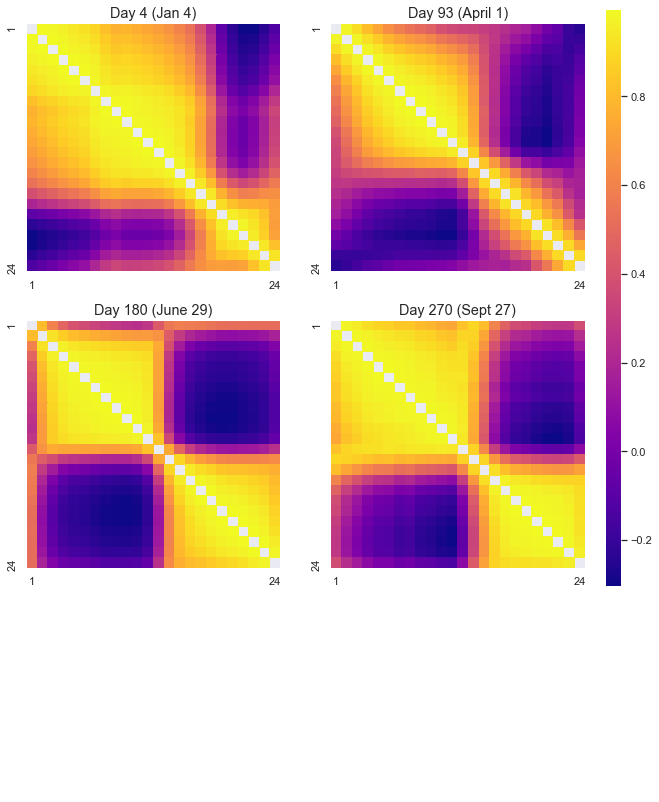

In [9]:
corrs = []
for k in range(366):
    cov = np.linalg.inv(theta[k])
    corr_mtx = np.zeros((24,24))
    for i in range(24):
        for j in range(24):
            corr_mtx[i,j] = cov[i,j]/np.sqrt(cov[i,i]*cov[j,j])
            if i == j: corr_mtx[i,j] = None
    corrs += [corr_mtx]
    
sns.set()
#tick labels
l = [None]*24
l[0] = 1
l[-1] = 24

num_figs = 10

fig, ax = plt.subplots(2,2, figsize=(10,10), tight_layout=False)

cbar_ax = fig.add_axes([.93, .1, .02, .8])

fig_idx = np.array([[4, 93], [180, 270]])

doy = np.array([["Jan 4", "April 1"], ["June 29", "Sept 27"]])

season = np.array([["Winter", "Spring"], ["Summer", "Autumn"]])

g = []
for i in range(2):
    for j in range(2):
        start_day = 1
        
        idx = fig_idx[i,j]

        sns.heatmap(corrs[idx], cmap="plasma", cbar=True, ax=ax[i,j],
                   xticklabels=l, yticklabels=l, cbar_ax=cbar_ax)

        ax[i,j].set_title("Day " + str(idx) + " (" + doy[i,j] + ")", fontsize="large")
    
plt.show()

127
215


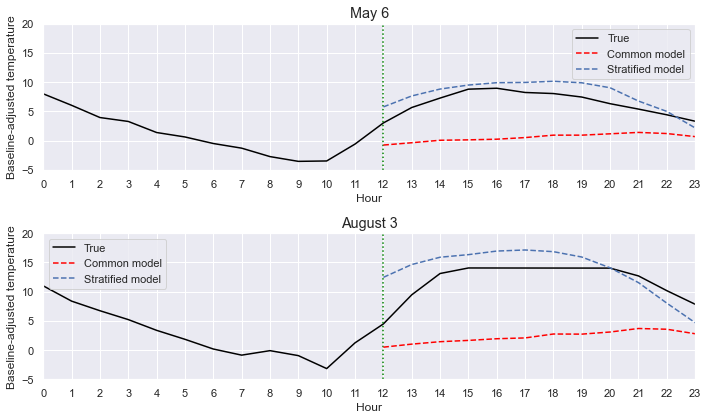

strat 6.091151301221585
common 8.124490417460176


In [10]:
rmse_strat = []
rmse_common = []
Sigma_z_common = np.linalg.inv(theta_common[0])

fig, ax = plt.subplots(2,1, figsize=(10,6))

dates = dict()
dates[127] = "May 6"
dates[215] = "August 3"


hrs = [i for i in range(24)]

for (i, (z,y)) in enumerate(zip(zs_test, ys_test)):

    hr_split = 12
    x1 = y[hr_split:][::-1]
    x2 = y[:hr_split][::-1]

    Sigma_z_strat = np.linalg.inv(theta[z])[::-1].T[::-1]

    S11 = Sigma_z_strat[:24-hr_split, :24-hr_split]
    S22 = Sigma_z_strat[24-hr_split:, 24-hr_split:]
    S12 = Sigma_z_strat[:24-hr_split, 24-hr_split:]

    x1_strat = S12@np.linalg.inv(S22)@(x2)
    
    rmse_strat += [np.sqrt(((x1-x1_strat)**2).mean())]

    S11 = Sigma_z_common[:24-hr_split, :24-hr_split]
    S22 = Sigma_z_common[24-hr_split:, 24-hr_split:]
    S12 = Sigma_z_common[:24-hr_split, 24-hr_split:]

    x1_common = S12@np.linalg.inv(S22)@(x2)
    
    rmse_common += [np.sqrt(((x1-x1_common)**2).mean())]
    
    
    if i == 127:
        j=0
    if i == 215:
        j=1
    
    if i==127 or i==215:
        print(i)

        ax[j].set_xlim(0,23)
        ax[j].set_ylim(-5, 20)
        ax[j].plot(range(24), y, color="black", label="True")
        ax[j].axvline(12, color="green", linestyle="dotted")
        ax[j].plot(range(12, 24), x1_common, "--", color="red", label="Common model")
        ax[j].plot(range(12, 24), x1_strat, "--", label="Stratified model")
        ax[j].set_xlabel("Hour", fontsize="medium")
        ax[j].set_ylabel("Baseline-adjusted temperature",fontsize="medium")
        ax[j].set_title(dates[i], fontsize="large")
        ax[j].set_xticks(hrs)
        ax[j].legend()
        
plt.tight_layout()
plt.show()
        
print("strat", np.mean(rmse_strat))
print("common", np.mean(rmse_common))